In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 1) Imports 및 디렉터리 설정
# ──────────────────────────────────────────────────────────────────────────────
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import heapq
import logging
from collections import deque
from enum import Enum
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # 구글 드라이브 기준 폴더 지정
    BASE_DIR    = '/content/drive/MyDrive/AICC_Project_0608_v2_final'
else:
    BASE_DIR    = './AICC_Project_0608_v2_test'

RESULTS_DIR = os.path.join(BASE_DIR, 'results')
PLOTS_DIR   = os.path.join(BASE_DIR, 'plots')
MODELS_DIR  = os.path.join(BASE_DIR, 'models')

for dir_path in [BASE_DIR, RESULTS_DIR, PLOTS_DIR, MODELS_DIR]:
    os.makedirs(dir_path, exist_ok=True)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
logger.info(f"Base Directory: {BASE_DIR}")
logger.info(f"Results will be saved to: {RESULTS_DIR}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA 사용 가능 여부:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("사용 중인 디바이스:", torch.cuda.get_device_name(0))
else:
    print("사용 중인 디바이스: CPU")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CUDA 사용 가능 여부: False
사용 중인 디바이스: CPU


In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 2) Config 클래스 정의 (FCR 보너스 포함)
# ──────────────────────────────────────────────────────────────────────────────
class AICCConfig:
    """Simulation을 위한 하이퍼파라미터 및 상수 집합."""
    def __init__(self):
        # 1) Reproducibility
        self.random_seed = 42

        # 2) Customer 정보
        self.customer_lifetime_value       = 890.18
        self.customer_lifetime_inquiries    = 122
        self.call_value                     = self.customer_lifetime_value / self.customer_lifetime_inquiries

        # **도착률** (Poisson 분포 파라미터: per minute)
        self.arrival_rate                   = 1.0

        # 문제 유형 분포
        self.problem_distribution           = {'easy': 0.4, 'hard': 0.6}

        # 고객 인내심 평균 (분 단위)
        self.customer_patience_mean         = 2.0

        # 고객 대기 비용 (분당)
        self.customer_wait_cost_per_minute  = 2.87

        # Fallback 패널티 비율 (resolved 실패 시 부과)
        self.fallback_penalty_rate          = 0.16

        # 문제 유형별 가치 가중치
        self.problem_value_multiplier       = {'easy': 1.0, 'hard': 1.5}

        # ***추가: FCR 보너스 비율 (첫 통화 해결 시 추가 보상)***
        self.fcr_bonus_rate                 = 0.47

        # 3) Call center 정보
        # 운영 시간 (분 단위, 예: 8시간 = 480분)
        self.operating_hours = 480

        # 4) AI Agent 정보
        self.num_ai_agents      = 100
        self.ai_cost_per_minute = 0.08
        self.ai_success_rate    = {'easy': 0.7, 'hard': 0.2}
        self.ai_time_multiplier = 0.6  # talk_time 및 ACW에 곱해지는 계수

        # 5) Human Agent 정보
        self.num_human_agents     = 3
        self.human_cost_per_minute = 0.33
        self.human_success_rate    = {'easy': 1.0, 'hard': 1.0}

        # 6) 통화 처리 시간 범위 (분 단위)
        self.talk_time_range = {'easy': (3, 6), 'hard': (6, 10)}
        self.acw_time_range  = {'easy': (30/60, 50/60), 'hard': (50/60, 70/60)}

        # 7) 휴리스틱 대기 시간 (분 단위)
        self.baseline_wait_time = {'easy': 5.0, 'hard': 8.0}

        # 8) 디렉터리 경로
        self.results_dir = RESULTS_DIR
        self.plots_dir   = PLOTS_DIR
        self.models_dir  = MODELS_DIR

# Config 인스턴스 생성
config = AICCConfig()

# CuDNN을 결정론적으로 설정 (속도 저하 감수)
torch.backends.cudnn.deterministic = True

# 3) 시드 설정 함수 및 초기 호출
def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False

set_random_seed(config.random_seed)
logger.info(f"Global random seed set to: {config.random_seed}")


In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 4) Domain Model: Customer 및 Agent 클래스
# ──────────────────────────────────────────────────────────────────────────────
class Customer:
    """고객 데이터 필드 및 상태 추적."""
    def __init__(self, customer_id: int, arrival_time: float, problem_type: str, patience: float):
        self.customer_id        = customer_id
        self.arrival_time       = arrival_time
        self.problem_type       = problem_type  # 'easy' 또는 'hard'
        self.patience           = patience

        # 상태 추적용 필드
        self.wait_start_time    = None
        self.service_start_time = None
        self.service_end_time   = None
        self.total_wait_time    = 0.0
        self.ai_service_time    = 0.0
        self.human_service_time = 0.0

        self.resolved         = False
        self.dropped_out      = False
        self.is_fcr           = False  # 첫 통화 해결 여부
        self.had_fallback     = False

        # 라우팅 정보
        self.initial_routing  = None  # 0=AI, 1=Human
        self.final_routing    = None  # 0=AI, 1=Human, -1=Failed

        # 이벤트 추적(드롭아웃 예약 ID)
        self.dropout_event_id = None
        self.reward           = 0.0  # 최종 reward 저장

class Agent:
    """AI 및 Human 공통 Agent 기본 클래스."""
    def __init__(self, agent_id: str, agent_type: str):
        self.agent_id               = agent_id
        self.agent_type             = agent_type  # 'ai' 또는 'human'
        self.is_busy                = False
        self.current_customer       = None
        self.service_end_time       = None
        self.total_service_time     = 0.0
        self.total_customers_served = 0

    def start_service(self, customer: Customer, current_time: float, duration: float):
        self.is_busy              = True
        self.current_customer     = customer
        self.service_end_time     = current_time + duration
        customer.service_start_time = current_time

    def finish_service(self):
        if self.current_customer:
            service_time = self.service_end_time - self.current_customer.service_start_time
            service_time = max(0.0, service_time)
            self.total_service_time += service_time
            self.total_customers_served += 1

            if self.agent_type == 'ai':
                self.current_customer.ai_service_time += service_time
            else:
                self.current_customer.human_service_time += service_time

        self.is_busy          = False
        self.current_customer = None
        self.service_end_time = None

class AIAgent(Agent):
    """AI Agent 구현."""
    def __init__(self, agent_id: int, config: AICCConfig):
        super().__init__(f"AI_{agent_id}", 'ai')
        self.config = config

    def get_service_time(self, problem_type: str) -> float:
        talk_min, talk_max = self.config.talk_time_range[problem_type]
        acw_min, acw_max   = self.config.acw_time_range[problem_type]
        talk_time = np.random.uniform(talk_min, talk_max) * self.config.ai_time_multiplier
        acw_time  = np.random.uniform(acw_min, acw_max) * self.config.ai_time_multiplier
        return talk_time + acw_time

    def can_resolve(self, problem_type: str) -> bool:
        return np.random.random() < self.config.ai_success_rate[problem_type]

class HumanAgent(Agent):
    """Human Agent 구현."""
    def __init__(self, agent_id: int, config: AICCConfig):
        super().__init__(f"Human_{agent_id}", 'human')
        self.config = config

    def get_service_time(self, problem_type: str) -> float:
        talk_min, talk_max = self.config.talk_time_range[problem_type]
        acw_min, acw_max   = self.config.acw_time_range[problem_type]
        talk_time = np.random.uniform(talk_min, talk_max)
        acw_time  = np.random.uniform(acw_min, acw_max)
        return talk_time + acw_time

    def can_resolve(self, problem_type: str) -> bool:
        return True


In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 5) Event System: EventType 및 Event 클래스 정의
# ──────────────────────────────────────────────────────────────────────────────
class EventType(Enum):
    SERVICE_COMPLETION = 1
    DROPOUT            = 2
    ARRIVAL            = 3
    CLOSING            = 4

class Event:
    """우선순위 큐 스케줄링용 이벤트 객체."""
    def __init__(self, event_type: EventType, time: float, customer=None, agent=None, event_id=None):
        self.event_type = event_type
        self.time       = time
        self.customer   = customer
        self.agent      = agent
        self.event_id   = event_id
        self.cancelled  = False

    def __lt__(self, other):
        ε = 1e-6
        if abs(self.time - other.time) > ε:
            return self.time < other.time
        return self.event_type.value < other.event_type.value


In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 6) Routing Policy: 다양한 정책 클래스 정의
# ──────────────────────────────────────────────────────────────────────────────
class RoutingPolicy:
    def __init__(self, name: str):
        self.name = name

    def route(self, customer: Customer, simulator_state: dict) -> int:
        raise NotImplementedError

class RandomRouting(RoutingPolicy):
    def __init__(self):
        super().__init__("Random")

    def route(self, customer: Customer, simulator_state: dict) -> int:
        return int(np.random.choice([0, 1]))

class TypeBasedRouting(RoutingPolicy):
    def __init__(self):
        super().__init__("Type-based")

    def route(self, customer: Customer, simulator_state: dict) -> int:
        return 0 if customer.problem_type == 'easy' else 1

class AIFirstRouting(RoutingPolicy):
    def __init__(self):
        super().__init__("AI-First")

    def route(self, customer: Customer, simulator_state: dict) -> int:
        return 0

class TimeThresholdRouting(RoutingPolicy):
    def __init__(self, threshold: float, config: AICCConfig):
        if config is None:
            raise ValueError("TimeThresholdRouting requires a valid config")
        super().__init__(f"Time-Threshold({threshold:.1f})")
        self.threshold = threshold
        self.config    = config

    def route(self, customer, state):
        q, fh = state['queue_length'], state['free_humans']
        # 1) avg service time 구하기
        tmin, tmax = self.config.talk_time_range[customer.problem_type]
        amin, amax = self.config.acw_time_range[customer.problem_type]
        avg_serv = (tmin + tmax)/2 + (amin + amax)/2

        # 2) expected wait
        if fh > 0:
            exp_wait = (q / fh) * avg_serv
        else:
            exp_wait = q * avg_serv

        # 3) threshold 비교
        return 1 if exp_wait <= self.threshold else 0

class CostBasedRouting(RoutingPolicy):
    def __init__(self, config: AICCConfig):
        super().__init__("Cost-Based")
        self.config = config

    def route(self, customer: Customer, simulator_state: dict) -> int:
        q_len        = simulator_state.get('queue_length', 0)
        free_humans  = simulator_state.get('free_humans', 0)
        problem_type = customer.problem_type

        # 평균 서비스 시간 계산
        talk_min, talk_max = self.config.talk_time_range[problem_type]
        acw_min, acw_max   = self.config.acw_time_range[problem_type]
        avg_talk   = (talk_min + talk_max) / 2
        avg_acw    = (acw_min + acw_max) / 2
        ai_time    = (avg_talk + avg_acw) * self.config.ai_time_multiplier
        human_time = avg_talk + avg_acw

        # AI 비용 + 실패 시 fallback 비용
        ai_cost           = ai_time * self.config.ai_cost_per_minute
        fallback_penalty  = self.config.call_value * self.config.fallback_penalty_rate
        fallback_prob     = 1 - self.config.ai_success_rate[problem_type]
        expected_ai_total_cost = ai_cost + fallback_prob * (
            human_time * self.config.human_cost_per_minute + fallback_penalty
        )

        # Human 쪽 예상 대기비용
        wait_time_est = 0 if free_humans > 0 else q_len * human_time
        expected_human_total_cost = wait_time_est * self.config.customer_wait_cost_per_minute + human_time * self.config.human_cost_per_minute

        return 0 if expected_ai_total_cost < expected_human_total_cost else 1


In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 7) UnifiedRewardCalculator: FCR 보너스 반영
# ──────────────────────────────────────────────────────────────────────────────
class UnifiedRewardCalculator:
    def __init__(self, config: AICCConfig):
        self.config = config

    def calculate_reward(self, customer: Customer) -> float:
        # 이미 계산된 경우 체크를 위한 플래그 추가
        if hasattr(customer, '_reward_calculated') and customer._reward_calculated:
            return customer.reward

        reward = 0.0

        # 1) 기본 해결 보상
        # === 해결 보상(조건 강화) ===
        if customer.resolved and customer.final_routing in [0, 1]:
            multiplier = self.config.problem_value_multiplier.get(customer.problem_type, 1.0)
            reward += self.config.call_value * multiplier

            # 2) 첫 통화 해결(FCR) 보너스
            if customer.is_fcr:
                reward += self.config.call_value * self.config.fcr_bonus_rate

        # 3) 대기 시간 패널티
        if customer.total_wait_time > 0:
            reward -= customer.total_wait_time * self.config.customer_wait_cost_per_minute

        # 4) AI 서비스 시간 비용
        if customer.ai_service_time > 0:
            reward -= customer.ai_service_time * self.config.ai_cost_per_minute

        # 5) Human 서비스 시간 비용
        if customer.human_service_time > 0:
            reward -= customer.human_service_time * self.config.human_cost_per_minute

        # 6) AI 실패 → 인간 폴백 패널티
        if customer.had_fallback:
            reward -= self.config.call_value * self.config.fallback_penalty_rate

        customer.reward = reward
        customer._reward_calculated = True
        return reward

unified_reward_calculator = UnifiedRewardCalculator(config)


In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 8) Simulator Core: AICCSimulator 클래스 정의 (get_state 최적화 반영)
# ──────────────────────────────────────────────────────────────────────────────
class AICCSimulator:
    def __init__(self, config: AICCConfig):
        self.config = config
        self.reset()

    def reset(self):
        self.current_time     = 0.0
        self.customer_counter = 0
        self.event_counter    = 0

        # Agents 초기화
        self.ai_agents        = [AIAgent(i, self.config) for i in range(self.config.num_ai_agents)]
        self.human_agents     = [HumanAgent(i, self.config) for i in range(self.config.num_human_agents)]
        self.idle_human_count = self.config.num_human_agents

        # 큐 및 이벤트 큐 초기화
        self.human_queue            = deque()
        self.event_queue            = []
        self.all_customers          = []
        self.completed_customer_stats = []

        # 통계 초기화
        self.total_arrivals   = 0
        self.total_resolved   = 0
        self.total_dropouts   = 0
        self.total_fcr        = 0
        self.total_fallbacks  = 0
        self.total_wait_time  = 0.0

        # 첫 Arrival 이벤트 예약
        self._schedule_next_arrival()

        # Closing 이벤트 예약
        closing_id   = self._get_next_event_id()
        closing_time = max(0.0, self.config.operating_hours)
        heapq.heappush(self.event_queue, Event(EventType.CLOSING, closing_time, event_id=closing_id))

        logger.debug("Simulator reset and initialized")

    def _get_next_event_id(self) -> str:
        self.event_counter += 1
        return f"event_{self.event_counter}"

    def _schedule_next_arrival(self):
        if self.current_time < self.config.operating_hours:
            inter_arrival = np.random.exponential(1.0 / self.config.arrival_rate)
            next_time     = self.current_time + inter_arrival
            if next_time < self.config.operating_hours:
                arrival_id = self._get_next_event_id()
                heapq.heappush(self.event_queue, Event(EventType.ARRIVAL, next_time, event_id=arrival_id))

    def _create_customer(self) -> Customer:
        self.customer_counter += 1
        problem_type = np.random.choice(
            ['easy', 'hard'],
            p=[self.config.problem_distribution['easy'], self.config.problem_distribution['hard']]
        )
        patience = np.random.exponential(self.config.customer_patience_mean)
        customer = Customer(self.customer_counter, self.current_time, problem_type, patience)
        self.all_customers.append(customer)
        self.total_arrivals += 1
        return customer

    def _get_available_human_agent(self):
        for agent in self.human_agents:
            if not agent.is_busy:
                return agent
        return None

    def _get_available_ai_agent(self):
        for agent in self.ai_agents:
            if not agent.is_busy:
                return agent
        return None

    def _cancel_dropout_event(self, customer: Customer):
        if customer.dropout_event_id is None:
            return
        for ev in self.event_queue:
            if (ev.event_id == customer.dropout_event_id and
                ev.event_type == EventType.DROPOUT and
                ev.customer == customer):
                ev.cancelled = True
                break
        customer.dropout_event_id = None

    def route_customer(self, customer: Customer, action: int):
        if customer.resolved or customer.dropped_out:
            return
        customer.initial_routing = action
        if action == 1:
            self._route_to_human(customer)
        else:
            self._route_to_ai(customer)

    def _route_to_human(self, customer: Customer):
        available_agent = self._get_available_human_agent()
        if available_agent is not None:
            # 첫 통화 해결 여부 결정: initial_routing이 Human이므로 FCR -> True
            customer.is_fcr = (not customer.had_fallback)
            self._start_human_service(customer, available_agent)
        else:
            customer.wait_start_time = self.current_time
            self.human_queue.append(customer)
            dropout_time = self.current_time + customer.patience
            if dropout_time < self.config.operating_hours:
                event_id = self._get_next_event_id()
                customer.dropout_event_id = event_id
                heapq.heappush(
                    self.event_queue,
                    Event(EventType.DROPOUT, dropout_time, customer=customer, event_id=event_id)
                )

    def _route_to_ai(self, customer: Customer):
        available_agent = self._get_available_ai_agent()
        if available_agent is not None:
            self._start_ai_service(customer, available_agent)
        else:
            # AI 무한 가정: 새 에이전트 생성
            new_agent_id = len(self.ai_agents)
            new_agent = AIAgent(new_agent_id, self.config)
            self.ai_agents.append(new_agent)
            self._start_ai_service(customer, new_agent)

    def _start_human_service(self, customer: Customer, agent: HumanAgent):
        self._cancel_dropout_event(customer)
        service_time = agent.get_service_time(customer.problem_type)
        agent.start_service(customer, self.current_time, service_time)
        self.idle_human_count -= 1

        if customer.wait_start_time is not None:
            wait = self.current_time - customer.wait_start_time
            customer.total_wait_time += wait
            self.total_wait_time += wait
            customer.wait_start_time = None

        event_id = self._get_next_event_id()
        heapq.heappush(
            self.event_queue,
            Event(EventType.SERVICE_COMPLETION, agent.service_end_time, customer=customer, agent=agent, event_id=event_id)
        )

    def _start_ai_service(self, customer: Customer, agent: AIAgent):
        service_time = agent.get_service_time(customer.problem_type)
        agent.start_service(customer, self.current_time, service_time)
        event_id = self._get_next_event_id()
        heapq.heappush(
            self.event_queue,
            Event(EventType.SERVICE_COMPLETION, agent.service_end_time, customer=customer, agent=agent, event_id=event_id)
        )

    def _handle_service_completion(self, event: Event):
        agent = event.agent
        agent.finish_service()

        customer = event.customer
        if agent.agent_type == 'ai':
            self._handle_ai_service_completion(customer, agent)
        else:
            self._handle_human_service_completion(customer, agent)

        if agent.agent_type == 'human':
            self.idle_human_count += 1
            while self.human_queue:
                next_customer = self.human_queue.popleft()
                if not next_customer.dropped_out:
                    # 재통화 관련 코드 제거 - 단순히 다음 고객 서비스 시작
                    self._start_human_service(next_customer, agent)
                    break

    def _handle_ai_service_completion(self, customer: Customer, agent: AIAgent):
        if agent.can_resolve(customer.problem_type):
            customer.resolved = True
            customer.final_routing = 0
            # AI 첫 라우팅 성공 시에만 FCR
            if customer.initial_routing == 0 and not customer.had_fallback:
                customer.is_fcr = True
                self.total_fcr += 1
            self.total_resolved += 1
            self._finalize_customer(customer)
        else:
            customer.had_fallback = True
            customer.is_fcr = False  # AI 실패 시 FCR 불가
            self.total_fallbacks += 1
            if self.current_time >= self.config.operating_hours:
                customer.resolved = False
                customer.final_routing = -1
                self._finalize_customer(customer)
            else:
                self._route_to_human(customer)

    def _handle_human_service_completion(self, customer: Customer, agent: HumanAgent):
        customer.resolved = True
        customer.final_routing = 1
        self.total_resolved += 1
        # 첫 라우팅이 Human이고 fallback이 없는 경우에만 FCR
        if customer.initial_routing == 1 and not customer.had_fallback:
            customer.is_fcr = True
            self.total_fcr += 1
        self._finalize_customer(customer)

    def _handle_dropout(self, event: Event):
        if event.cancelled:
            return
        customer = event.customer
        if customer in self.human_queue and not customer.dropped_out:
            customer.dropped_out      = True
            customer.resolved         = False
            customer.final_routing    = -1
            self.total_dropouts       += 1

            if customer.wait_start_time is not None:
                wait = self.current_time - customer.wait_start_time
                customer.total_wait_time += wait
                self.total_wait_time    += wait
                customer.wait_start_time = None

            try:
                self.human_queue.remove(customer)
            except ValueError:
                pass

            self._finalize_customer(customer)

    def _handle_closing(self, event: Event):
        while self.human_queue:
            customer = self.human_queue.popleft()
            if not customer.dropped_out:
                customer.dropped_out = True
                customer.resolved = False
                customer.final_routing = -1
                self.total_dropouts += 1
                self._finalize_customer(customer)

        # 2) 상담 중인 고객 처리 (추가)
        for agent in self.ai_agents:
            if agent.is_busy and agent.current_customer:
                customer = agent.current_customer
                agent.finish_service()  # 서비스 시간 누적 (이게 핵심)
                if agent.can_resolve(customer.problem_type):
                    customer.resolved = True
                    customer.final_routing = 0
                    if customer.initial_routing == 0 and not customer.had_fallback:
                        customer.is_fcr = True
                        self.total_fcr += 1
                    self.total_resolved += 1
                else:
                    # 실패 & 휴먼 불가
                    customer.resolved = False
                    customer.dropped_out = True
                    customer.final_routing = -1
                    self.total_dropouts += 1
                self._finalize_customer(customer)

        for agent in self.human_agents:
            if agent.is_busy and agent.current_customer:
                customer = agent.current_customer
                agent.finish_service()  # 서비스 시간 누적 (이것도 필수)
                customer.resolved = True
                customer.final_routing = 1
                if customer.initial_routing == 1 and not customer.had_fallback:
                    customer.is_fcr = True
                    self.total_fcr += 1
                self.total_resolved += 1
                self._finalize_customer(customer)

    def _finalize_customer(self, customer: Customer):
        # === 중복 finalize 방지: 이미 finalize된 고객은 스킵 ===
        if hasattr(customer, '_finalized') and customer._finalized:
            return
        customer._finalized = True

        if customer.resolved:
            customer.dropped_out = False
        elif customer.dropped_out:
            customer.resolved = False
        elif not customer.resolved and not customer.dropped_out:
            # 둘 다 False면 강제 드롭
            customer.dropped_out = True

        assert customer.resolved != customer.dropped_out, (
            f"resolved={customer.resolved}, dropped_out={customer.dropped_out} for customer_id={customer.customer_id}"
        )

        # is_fcr/had_fallback 둘 다 True만 금지
        if customer.is_fcr and customer.had_fallback:
            raise AssertionError(
                f"is_fcr={customer.is_fcr}, had_fallback={customer.had_fallback} for customer_id={customer.customer_id}"
            )

        # 4. 보상 계산
        unified_reward_calculator.calculate_reward(customer)

        # 5. summary 저장
        summary = {
            'customer_id':        customer.customer_id,
            'problem_type':       customer.problem_type,
            'resolved':           customer.resolved,
            'dropped_out':        customer.dropped_out,
            'is_fcr':             customer.is_fcr,
            'had_fallback':       customer.had_fallback,
            'total_wait_time':    customer.total_wait_time,
            'ai_service_time':    customer.ai_service_time,
            'human_service_time': customer.human_service_time,
            'initial_routing':    customer.initial_routing,
            'final_routing':      customer.final_routing,
            'reward':             customer.reward
        }
        self.completed_customer_stats.append(summary)


    def step(self):
        if not self.event_queue:
            return None, True

        # 취소되지 않은 다음 이벤트 찾기
        event = None
        while self.event_queue:
            candidate = heapq.heappop(self.event_queue)
            if not candidate.cancelled:
                event = candidate
                break
        if event is None:
            return None, True

        self.current_time = event.time

        if event.event_type == EventType.ARRIVAL:
            customer = self._create_customer()
            self._schedule_next_arrival()
            return customer, False
        elif event.event_type == EventType.SERVICE_COMPLETION:
            self._handle_service_completion(event)
            return None, False
        elif event.event_type == EventType.DROPOUT:
            self._handle_dropout(event)
            return None, False
        elif event.event_type == EventType.CLOSING:
            self._handle_closing(event)
            return None, False

        return None, False

    def get_state(self, customer: Customer) -> np.ndarray:
        """4차원 통일된 상태 반환"""
        queue_length = len(self.human_queue)
        free_humans = self.config.num_human_agents - sum(a.is_busy for a in self.human_agents)
        problem_difficulty = 1.0 if customer.problem_type == 'hard' else 0.0
        remaining_time_ratio = max(0.0, self.config.operating_hours - self.current_time) / self.config.operating_hours

        return np.array([
            min(queue_length / 10.0, 1.0),  # 대기열 길이 정규화
            free_humans / self.config.num_human_agents,  # 가용 인력 비율
            problem_difficulty,  # 문제 난이도 (0 또는 1)
            remaining_time_ratio  # 잔여 시간 비율
        ], dtype=np.float32)

    # 모든 정책에서 동일한 상태 사용
    def get_state_dict(self, customer: Customer) -> dict:
        state_array = self.get_state(customer)
        return {
            'queue_length': len(self.human_queue),
            'free_humans': self.config.num_human_agents - sum(a.is_busy for a in self.human_agents),
            'problem_difficulty': 1.0 if customer.problem_type == 'hard' else 0.0,
            'remaining_time_ratio': state_array[3]
        }

    def calculate_reward(self, customer: Customer) -> float:
        return unified_reward_calculator.calculate_reward(customer)

    def get_simulation_results(self):
        total_customers = self.total_arrivals
        if total_customers == 0:
            return {
                'total_customers':   0,
                'resolution_rate':   0.0,
                'dropout_rate':      0.0,
                'fcr_rate':          0.0,
                'fallback_rate':     0.0,
                'avg_wait_time':     0.0,
                'ai_success_rate':   0.0,
                'human_utilization': 0.0,
                'asa':               0.0,
                'aht':               0.0,
                'abandonment_rate':  0.0
            }

        resolution_rate = self.total_resolved / total_customers
        total_unresolved = total_customers - self.total_resolved
        dropout_rate = total_unresolved / total_customers
        fcr_rate      = self.total_fcr / total_customers
        fallback_rate = self.total_fallbacks / total_customers

        wait_times = [
            s['total_wait_time']
            for s in self.completed_customer_stats
            if s['total_wait_time'] > 0
        ]
        avg_wait_time = np.mean(wait_times) if wait_times else 0.0

        ai_customers     = [s for s in self.completed_customer_stats if s['initial_routing'] == 0]
        ai_success_count = sum(1 for s in ai_customers if s['final_routing'] == 0)
        ai_success_rate  = ai_success_count / len(ai_customers) if ai_customers else 0.0

        total_human_work_time = sum(a.total_service_time for a in self.human_agents)
        human_utilization     = (
            total_human_work_time
            / (self.config.num_human_agents * self.config.operating_hours)
            if self.config.operating_hours > 0 else 0.0
        )

        answered_customers = [s for s in self.completed_customer_stats if s['resolved']]
        asa = (
            np.mean([s['total_wait_time'] for s in answered_customers])
            if answered_customers else 0.0
        )

        handle_times = [
            s['ai_service_time'] + s['human_service_time'] for s in answered_customers
        ]
        aht = np.mean(handle_times) if handle_times else 0.0

        abandonment_rate = self.total_dropouts / total_customers

        return {
            'total_customers':   total_customers,
            'resolution_rate':   resolution_rate,
            'dropout_rate':      dropout_rate,
            'fcr_rate':          fcr_rate,
            'fallback_rate':     fallback_rate,
            'avg_wait_time':     avg_wait_time,
            'ai_success_rate':   ai_success_rate,
            'human_utilization': human_utilization,
            'asa':               asa,
            'aht':               aht,
            'abandonment_rate':  abandonment_rate
        }


In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 9) run_simulation_with_policy 및 run_simulation_with_rl 함수 정의
# ──────────────────────────────────────────────────────────────────────────────
def run_simulation_with_policy(policy, seed=42):
    """
    Baseline 정책(policy)을 사용해 전체 에피소드를 시뮬레이션하고 KPI 반환.
    """
    if seed is not None:
        set_random_seed(seed)

    simulator = AICCSimulator(config)
    done = False

    while not done:
        customer, done = simulator.step()
        if customer is not None:
            state_dict = {
                'queue_length': len(simulator.human_queue),
                'free_humans':  config.num_human_agents - sum(a.is_busy for a in simulator.human_agents)
            }
            action = policy.route(customer, state_dict)
            simulator.route_customer(customer, action)

    total_reward = sum(c.reward for c in simulator.all_customers)
    metrics = simulator.get_simulation_results()
    metrics['total_reward'] = total_reward
    return metrics

def run_simulation_with_rl(policy_obj, seed=42):
    """
    RL 정책(policy_obj)을 사용한 시뮬레이션 함수.
    최종적으로 모든 고객의 reward를 합산하여 반환한다.
    """
    if seed is not None:
        set_random_seed(seed)

    simulator = AICCSimulator(config)
    done = False
    customer = None

    # 첫 고객 등장 대기
    while not done and customer is None:
        customer, done = simulator.step()

    # 에피소드 루프
    while not done:
        # customer가 없으면 다음 고객이 올 때까지 step() 호출
        if customer is None:
            while not done and customer is None:
                customer, done = simulator.step()
            if done:
                break

        # 유효한 customer가 있을 때 행동 선택 및 라우팅
        action = policy_obj.route(customer, simulator)
        simulator.route_customer(customer, action)

        # 다음 고객 얻기
        customer, done = simulator.step()

    # 시뮬레이션 종료 후 모든 고객의 reward를 한 번에 합산
    total_reward = sum(c.reward for c in simulator.all_customers)

    metrics = simulator.get_simulation_results()
    metrics['total_reward'] = total_reward
    return metrics


In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 10) Baseline 정책별 평가 및 보상 분해 정보
# ──────────────────────────────────────────────────────────────────────────────
baseline_policies = {
    "Random":      RandomRouting(),
    "Type-based":  TypeBasedRouting(),
    "AI-First":    AIFirstRouting(),
    "Cost-Based":  CostBasedRouting(config)
}

# TimeThreshold 최적값 탐색
param_grid = {'threshold': np.arange(0.0, 10.1, 0.05)}
grid = list(ParameterGrid(param_grid))
results = []
n_runs = 10

for params in grid:
    thr = params['threshold']
    rewards = [
        run_simulation_with_policy(TimeThresholdRouting(thr, config), seed=None)
        ['total_reward']
        for _ in range(n_runs)
    ]
    results.append({
        'threshold': thr,
        'mean_total_reward': np.mean(rewards)
    })

df_grid = pd.DataFrame(results)
best = df_grid.loc[df_grid['mean_total_reward'].idxmax()]
best_thr = best['threshold']

print(f"최적 Threshold: {best_thr}분 (평균 보상 {best['mean_total_reward']:.4f})")
baseline_policies[f"TimeThreshold({best_thr})"] = TimeThresholdRouting(best_thr, config)

# Baseline 평가 - 50회 반복으로 변경
results_detailed = []
for name, policy in tqdm(baseline_policies.items(), desc="Baseline Policies Evaluation"):
    for run in range(50):  # 50회 반복
        metrics = run_simulation_with_policy(policy, seed=None)
        metrics['policy'] = name
        metrics['run'] = run + 1
        results_detailed.append(metrics)

# 전체 상세 데이터 (250개 행)
df_baseline_detailed = pd.DataFrame(results_detailed)

# 원래 모양처럼 정책별 요약 (5개 행)
df_baseline_summary = df_baseline_detailed.groupby('policy').agg({
    'total_customers': 'mean',
    'resolution_rate': 'mean',
    'fcr_rate': 'mean',
    'avg_wait_time': 'mean',
    'total_reward': 'mean',
    'ai_success_rate': 'mean',
    'human_utilization': 'mean',
    'abandonment_rate': 'mean'
}).round(4).reset_index()

# 원래 모양대로 표시
print("=== Baseline 정책별 평균 성능 (50회 평균) ===")
display(df_baseline_summary)

최적 Threshold: 1.75분 (평균 보상 1801.3020)


Baseline Policies Evaluation: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it]

=== Baseline 정책별 평균 성능 (50회 평균) ===


,policy,total_customers,resolution_rate,fcr_rate,avg_wait_time,total_reward,ai_success_rate,human_utilization,abandonment_rate
0,AI-First,478.00,0.7251,0.4001,1.2802,2136.7289,0.3963,0.8641,0.2845
1,Cost-Based,475.40,0.6896,0.5362,1.2380,2221.5334,0.4942,0.9374,0.3189
2,Random,480.28,0.5696,0.4383,1.3191,1335.1857,0.4072,0.9257,0.4376
3,TimeThreshold(1.75),477.38,0.6211,0.4809,1.2166,1684.1329,0.3984,0.9674,0.3869
4,Type-based,480.14,0.6200,0.5661,1.3299,1959.4746,0.7085,0.9175,0.3873


In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 보상 분해 정보 - 50회 반복 평가
# ──────────────────────────────────────────────────────────────────────────────

# 1) 베이스라인 정책 정의(생략)

# 2) 고객 단위 보상+상태 분해 정보를 담을 리스트 (50회 반복)
breakdown_records = []

for name, policy in tqdm(baseline_policies.items(), desc="보상 분해 분석"):
    for run in range(50):  # 50회 반복
        sim = AICCSimulator(config)
        done = False

        # 시뮬레이션 수행
        while not done:
            cust, done = sim.step()
            if cust is not None:
                state = {
                    "queue_length": len(sim.human_queue),
                    "free_humans": config.num_human_agents - sum(a.is_busy for a in sim.human_agents)
                }
                action = policy.route(cust, state)
                sim.route_customer(cust, action)

        # 완료된 고객별 통계에서 보상·라우팅·시간정보 모두 계산
        for c in sim.completed_customer_stats:
            # 보상 요소 계산
            total_wait = c["total_wait_time"]
            ai_time = c["ai_service_time"]
            human_time = c["human_service_time"]
            resolved = c["resolved"]
            is_fcr = c["is_fcr"]
            had_fallback = c["had_fallback"]
            problem_type = c["problem_type"]

            base_value = config.call_value * config.problem_value_multiplier[problem_type] if resolved else 0.0
            fcr_bonus = config.call_value * config.fcr_bonus_rate if is_fcr else 0.0
            wait_penalty = total_wait * config.customer_wait_cost_per_minute
            ai_cost = ai_time * config.ai_cost_per_minute
            human_cost = human_time * config.human_cost_per_minute
            fallback_penalty = config.call_value * config.fallback_penalty_rate if had_fallback else 0.0

            breakdown_records.append({
                "policy": name,
                "run": run + 1,
                "customer_id": c["customer_id"],

                # ─── 리워드 구성 항목 ───
                "base_reward": base_value,
                "fcr_bonus": fcr_bonus,
                "wait_penalty": wait_penalty,
                "ai_cost": ai_cost,
                "human_cost": human_cost,
                "fallback_penalty": fallback_penalty,
                "total_reward": c["reward"],

                # ─── 라우팅 & 상태 정보 ───
                "initial_routing":    c["initial_routing"],    # 0=AI, 1=Human
                "final_routing":      c["final_routing"],      # 0=AI, 1=Human, -1=Failed
                "is_fcr":             c["is_fcr"],             # 첫 통화 해결 여부
                "total_wait_time":    total_wait,
                "ai_service_time":    ai_time,
                "human_service_time": human_time
            })

# 3) DataFrame으로 변환
df_breakdown = pd.DataFrame(breakdown_records)

# 4) 첫 20개 행 출력
print("=== 보상 분해 정보 (첫 20개 행) ===")
display(df_breakdown.head(20))


보상 분해 분석: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


=== 보상 분해 정보 (첫 20개 행) ===


,policy,run,customer_id,base_reward,fcr_bonus,wait_penalty,ai_cost,human_cost,fallback_penalty,total_reward,initial_routing,final_routing,is_fcr,total_wait_time,ai_service_time,human_service_time
0,Random,1,4,0.000000,0.000000,1.630898,0.000000,0.000000,0.000000,-1.630898,1,-1,False,0.568257,0.000000,0.000000
1,Random,1,5,0.000000,0.000000,8.145379,0.000000,0.000000,0.000000,-8.145379,1,-1,False,2.838111,0.000000,0.000000
2,Random,1,1,10.944836,3.429382,0.000000,0.000000,2.926739,0.000000,11.447479,1,1,True,0.000000,0.000000,8.868906
3,Random,1,7,0.000000,0.000000,5.905984,0.000000,0.000000,0.000000,-5.905984,1,-1,False,2.057834,0.000000,0.000000
4,Random,1,2,10.944836,3.429382,0.000000,0.000000,3.211015,0.000000,11.163203,1,1,True,0.000000,0.000000,9.730348
5,Random,1,8,0.000000,0.000000,0.712771,0.446025,0.000000,1.167449,-2.326245,0,-1,False,0.248352,5.575309,0.000000
6,Random,1,3,10.944836,3.429382,0.000000,0.000000,3.535883,0.000000,10.838335,1,1,True,0.000000,0.000000,10.714798
7,Random,1,16,0.000000,0.000000,0.402343,0.000000,0.000000,0.000000,-0.402343,1,-1,False,0.140189,0.000000,0.000000
8,Random,1,6,10.944836,3.429382,7.442182,0.000000,2.986973,0.000000,3.945063,1,1,True,2.593095,0.000000,9.051432
9,Random,1,12,7.296557,3.429382,0.000000,0.215067,0.000000,0.000000,10.510872,0,0,True,0.000000,2.688340,0.000000


In [ ]:
# 5) 정책별 항목 합계 계산 (50회 평균)
agg = df_breakdown.groupby("policy").agg({
    "base_reward":        ["mean", "std", "sum"],
    "fcr_bonus":          ["mean", "std", "sum"],
    "wait_penalty":       ["mean", "std", "sum"],
    "ai_cost":            ["mean", "std", "sum"],
    "human_cost":         ["mean", "std", "sum"],
    "fallback_penalty":   ["mean", "std", "sum"],
    "total_reward":       ["mean", "std", "sum"],
    "initial_routing":    lambda x: (x == 0).sum(),  # AI에 라우팅된 고객 수
    "final_routing":      lambda x: (x == 0).sum(),  # AI가 최종 처리한 고객 수
    "is_fcr":             "sum",                    # FCR(True)인 고객 수
    "total_wait_time":    ["mean", "std"],           # 평균 & 표준편차 대기 시간
    "ai_service_time":    ["mean", "std"],           # 평균 & 표준편차 AI 서비스 시간
    "human_service_time": ["mean", "std"],           # 평균 & 표준편차 Human 서비스 시간
}).reset_index()

# 5-1) 멀티인덱스 컬럼(flatten) 처리
agg.columns = [
    "policy",
    "total_reward_mean", "total_reward_std", "total_reward_sum",
    "base_reward_mean", "base_reward_std", "base_reward_sum",
    "fcr_bonus_mean", "fcr_bonus_std", "fcr_bonus_sum",
    "wait_penalty_mean", "wait_penalty_std", "wait_penalty_sum",
    "ai_cost_mean", "ai_cost_std", "ai_cost_sum",
    "human_cost_mean", "human_cost_std", "human_cost_sum",
    "fallback_penalty_mean", "fallback_penalty_std", "fallback_penalty_sum",
    "num_initial_to_ai",
    "num_final_by_ai",
    "num_fcr",
    "avg_wait_time_mean", "avg_wait_time_std",
    "avg_ai_service_time_mean", "avg_ai_service_time_std",
    "avg_human_service_time_mean", "avg_human_service_time_std"
]

# 6) 정책별 합계 출력
print("\n=== 정책별 보상 분해 통계 (50회 평균) ===")
display(agg)



=== 정책별 보상 분해 통계 (50회 평균) ===


,policy,total_reward_mean,total_reward_std,total_reward_sum,base_reward_mean,base_reward_std,base_reward_sum,fcr_bonus_mean,fcr_bonus_std,fcr_bonus_sum,...,fallback_penalty_sum,num_initial_to_ai,num_final_by_ai,num_fcr,avg_wait_time_mean,avg_wait_time_std,avg_ai_service_time_mean,avg_ai_service_time_std,avg_human_service_time_mean,avg_human_service_time_std
0,AI-First,6.604470,4.421720,158546.895246,1.373410,1.680420,32970.078233,1.592146,2.834152,38221.060621,...,107444.811466,24006,9614,9614,0.554755,0.987509,4.482105,1.293912,2.605095,3.967111
1,Cost-Based,6.176936,4.531709,148098.225082,1.801083,1.712549,43182.777731,1.807486,2.911512,43336.278970,...,110372.643666,16618,8150,12592,0.629786,1.014464,2.826083,2.164376,2.824734,4.102556
2,Random,5.168956,4.803223,125931.283770,1.459138,1.695575,35548.973472,2.499270,3.259143,60889.726028,...,65665.469715,12293,4956,10366,0.870826,1.135590,2.255419,2.414087,2.743622,3.908342
3,TimeThreshold(1.75),5.623265,4.718134,135048.332213,1.614020,1.711769,38762.304375,2.166709,2.949391,52035.682680,...,83760.252660,14230,5634,11303,0.754951,1.027662,2.649682,2.411189,2.901151,3.958634
4,Type-based,5.448794,4.579429,132111.467869,1.904505,1.704188,46176.628189,2.198817,3.188158,53312.507676,...,97272.804120,9764,6845,13465,0.766138,1.110857,1.247015,1.554202,2.736747,4.052177


In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 11) Training Module: ReplayBuffer 및 DQN 계열 네트워크 정의 (풀버전)
# ──────────────────────────────────────────────────────────────────────────────
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
import numpy as np
from tqdm import tqdm

# CUDNN 설정: 비결정론적 + 벤치마크 모드 활성화
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark     = True

class ReplayBuffer:
    def __init__(self, capacity: int = 5000):
        self.capacity = capacity
        self.buffer   = deque(maxlen=capacity)

    def push(self, state: np.ndarray, action: int, reward: float, next_state: np.ndarray, done: float):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.stack, zip(*batch))
        return (
            torch.tensor(states, dtype=torch.float32, device=device),
            torch.tensor(actions, dtype=torch.long, device=device).unsqueeze(1),
            torch.tensor(rewards, dtype=torch.float32, device=device).unsqueeze(1),
            torch.tensor(next_states, dtype=torch.float32, device=device),
            torch.tensor(dones, dtype=torch.float32, device=device).unsqueeze(1)
        )

    def __len__(self) -> int:
        return len(self.buffer)

class DQNNetwork(nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int = 64, dropout_p: float = 0.1):
        super(DQNNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.do1 = nn.Dropout(p=dropout_p)

        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.do2 = nn.Dropout(p=dropout_p)

        self.fc3 = nn.Linear(hidden_dim, action_dim)

        # 가중치 초기화
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='linear')
        if self.fc1.bias is not None: nn.init.constant_(self.fc1.bias, 0)
        if self.fc2.bias is not None: nn.init.constant_(self.fc2.bias, 0)
        if self.fc3.bias is not None: nn.init.constant_(self.fc3.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.ln1(self.fc1(x)))
        x = self.do1(x)
        x = F.relu(self.ln2(self.fc2(x)))
        x = self.do2(x)
        return self.fc3(x)

class DuelingDQNNetwork(nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int = 64, dropout_p: float = 0.1):
        super(DuelingDQNNetwork, self).__init__()
        self.fc1      = nn.Linear(state_dim, hidden_dim)
        self.ln1      = nn.LayerNorm(hidden_dim)
        self.do1      = nn.Dropout(p=dropout_p)

        # Value stream
        self.fc_value = nn.Linear(hidden_dim, hidden_dim)
        self.ln_v     = nn.LayerNorm(hidden_dim)
        self.do_v     = nn.Dropout(p=dropout_p)
        self.value_out= nn.Linear(hidden_dim, 1)

        # Advantage stream
        self.fc_adv   = nn.Linear(hidden_dim, hidden_dim)
        self.ln_a     = nn.LayerNorm(hidden_dim)
        self.do_a     = nn.Dropout(p=dropout_p)
        self.adv_out  = nn.Linear(hidden_dim, action_dim)

        # 가중치 초기화
        for layer in [self.fc1, self.fc_value, self.fc_adv, self.value_out, self.adv_out]:
            nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.ln1(self.fc1(x)))
        x = self.do1(x)

        v = F.relu(self.ln_v(self.fc_value(x)))
        v = self.do_v(v)
        v = self.value_out(v)

        a = F.relu(self.ln_a(self.fc_adv(x)))
        a = self.do_a(a)
        a = self.adv_out(a)

        return v + (a - a.mean(dim=1, keepdim=True))

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 13) DQN / Double DQN / Dueling DQN 학습 및 저장 (에피소드 단위 처리)
# ──────────────────────────────────────────────────────────────────────────────
import os
import matplotlib.pyplot as plt

num_episodes = 3000

def train_dqn_episode_based(
    env_class,
    config,
    network_type: str = "DQN",
    num_episodes: int = 7000,
    batch_size: int = 32,
    gamma: float = 0.98,
    lr: float = 5e-4,
    buffer_capacity: int = 8000,
    target_update_freq: int = 20,
    epsilon_start: float = 1.0,
    epsilon_final: float = 0.05,
    epsilon_decay: int = 700,
    hidden_dim: int = 128,
    dropout_p: float = 0.1
):
    state_dim = 4
    action_dim = 2

    if network_type == "DuelingDQN":
        policy_net = DuelingDQNNetwork(state_dim, action_dim, hidden_dim=hidden_dim, dropout_p=dropout_p).to(device)
        target_net = DuelingDQNNetwork(state_dim, action_dim, hidden_dim=hidden_dim, dropout_p=dropout_p).to(device)
    else:
        policy_net = DQNNetwork(state_dim, action_dim, hidden_dim=hidden_dim, dropout_p=dropout_p).to(device)
        target_net = DQNNetwork(state_dim, action_dim, hidden_dim=hidden_dim, dropout_p=dropout_p).to(device)

    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    replay_buffer = ReplayBuffer(capacity=buffer_capacity)
    loss_fn = nn.SmoothL1Loss()

    epsilon_by_episode = lambda ep: epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1.0 * ep / epsilon_decay)

    losses = []
    all_rewards = []

    for episode in tqdm(range(1, num_episodes + 1), desc=f"{network_type} Training"):
        env = env_class(config)
        episode_transitions = []
        done = False

        # 1단계: 전체 에피소드 실행
        while not done:
            customer, done = env.step()
            if customer is not None:
                state = env.get_state(customer)

                # 행동 선택
                eps = epsilon_by_episode(episode)
                if random.random() < eps:
                    action = random.randrange(action_dim)
                else:
                    state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                    with torch.no_grad():
                        q_vals = policy_net(state_tensor)
                        action = int(q_vals.argmax(dim=1).item())

                # 라우팅 실행
                env.route_customer(customer, action)

                # transition 저장 (보상은 나중에 shaping 포함해 할당)
                episode_transitions.append({
                    'state': state,
                    'action': action,
                    'customer': customer
                })

        # 2단계: 에피소드 완료 후 보상+shaping 할당 및 버퍼에 추가
        total_episode_reward = 0.0
        for i, trans in enumerate(episode_transitions):
            customer = trans['customer']
            action = trans['action']
            reward = unified_reward_calculator.calculate_reward(customer)

            # ────────────── Reward Shaping ──────────────
            shaping = 0.0
            if customer.problem_type == 'hard':
                if action == 1:     # hard-human
                    shaping += 1.0
                else:               # hard-ai
                    shaping -= 1.0
            if customer.problem_type == 'easy':
                if action == 0:     # easy-ai
                    shaping += 0.5
            if customer.dropped_out:
                shaping -= 2.0
            if customer.had_fallback:
                shaping -= 1.0
            shaping -= customer.total_wait_time * 0.1  # wait time penalty
            shaped_reward = reward * 0.01 + shaping    # 기존 reward 신호는 줄이고 shaping만 부각

            total_episode_reward += shaped_reward

            # 다음 상태
            if i + 1 < len(episode_transitions):
                next_state = episode_transitions[i + 1]['state']
                done_flag = False
            else:
                next_state = np.array([0.0, 1.0, 0.0, 0.0], dtype=np.float32)
                done_flag = True

            # 리플레이 버퍼에 저장
            replay_buffer.push(
                trans['state'],
                trans['action'],
                shaped_reward,
                next_state,
                done_flag
            )

        all_rewards.append(total_episode_reward)

        # 3단계: 학습 (충분한 데이터가 있을 때)
        if len(replay_buffer) >= batch_size:
            states_b, actions_b, rewards_b, next_states_b, dones_b = replay_buffer.sample(batch_size)

            q_vals = policy_net(states_b).gather(1, actions_b)

            with torch.no_grad():
                if network_type == "DoubleDQN":
                    next_actions = policy_net(next_states_b).argmax(dim=1, keepdim=True)
                    next_q = target_net(next_states_b).gather(1, next_actions)
                else:
                    next_q = target_net(next_states_b).max(dim=1, keepdim=True)[0]
                target_q = rewards_b + gamma * next_q * (1 - dones_b)

            loss = loss_fn(q_vals, target_q)

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=1.0)
            optimizer.step()

            losses.append(loss.item())

        # 타겟 네트워크 업데이트
        if episode % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if episode % 50 == 0:
            avg_loss = np.mean(losses[-50:]) if losses else 0.0
            avg_reward = np.mean(all_rewards[-50:])
            tqdm.write(f"Episode {episode} | AvgLoss: {avg_loss:.4f} | AvgRew: {avg_reward:.4f} | Eps: {eps:.3f}")

    return losses, all_rewards, policy_net


In [ ]:
# 모든 정책 통합 (baseline + RL)
all_policies = {**baseline_policies, **rl_policies}

# 결과 기록용 리스트
records = []

# 100회 반복 테스트
n_runs = 100

for policy_name, policy in tqdm(all_policies.items(), desc="Simulations per Policy"):
    for run in range(1, n_runs + 1):
        # 시드 설정
        set_random_seed(config.random_seed + run)

        # 시뮬레이터 초기화
        sim = AICCSimulator(config)
        done = False

        # 시뮬레이션 실행
        while not done:
            customer, done = sim.step()
            if customer is not None:
                state = sim.get_state_dict(customer)
                customer.initial_queue       = state['queue_length']
                customer.initial_free_humans = state['free_humans']
                action = policy.route(customer, sim) if isinstance(policy, RLPolicy) \
                         else policy.route(customer, state)
                customer.initial_action = action
                sim.route_customer(customer, action)

        # run-level ASA & AHT 계산 (응답된 고객 기준)
        answered = [c for c in sim.all_customers if c.resolved]
        asa = np.mean([c.total_wait_time for c in answered]) if answered else 0.0
        aht = np.mean([c.ai_service_time + c.human_service_time for c in answered]) if answered else 0.0

        # 고객별 데이터 수집
        for cust in sim.all_customers:
            base_val      = config.call_value * config.problem_value_multiplier[cust.problem_type] if cust.resolved else 0.0
            fcr_val       = config.call_value * config.fcr_bonus_rate if cust.is_fcr else 0.0
            wait_pen      = cust.total_wait_time * config.customer_wait_cost_per_minute
            ai_c          = cust.ai_service_time * config.ai_cost_per_minute
            human_c       = cust.human_service_time * config.human_cost_per_minute
            fallback_pen  = config.call_value * config.fallback_penalty_rate if cust.had_fallback else 0.0

            records.append({
                'policy':               policy_name,
                'run':                  run,
                'customer_id':          cust.customer_id,
                'initial_queue_length': cust.initial_queue,
                'initial_free_humans':  cust.initial_free_humans,
                'initial_action':       cust.initial_action,   # 0=AI, 1=Human
                'final_routing':        cust.final_routing,
                'resolved':             cust.resolved,
                'dropped_out':          cust.dropped_out,
                'is_fcr':               cust.is_fcr,
                'had_fallback':         cust.had_fallback,
                'total_wait_time':      cust.total_wait_time,
                'ai_service_time':      cust.ai_service_time,
                'human_service_time':   cust.human_service_time,
                'asa':                  asa,    # run-level ASA
                'aht':                  aht,    # run-level AHT
                'base_reward':          base_val,
                'fcr_bonus':            fcr_val,
                'wait_penalty':         wait_pen,
                'ai_cost':              ai_c,
                'human_cost':           human_c,
                'fallback_penalty':     fallback_pen,
                'total_reward':         cust.reward
            })

# DataFrame으로 변환 및 저장
df_results = pd.DataFrame(records)
results_path = os.path.join(RESULTS_DIR, 'simulation_results.csv')
df_results.to_csv(results_path, index=False)
print(f"Saved complete results to: {results_path}")

Simulations per Policy: 100%|██████████| 6/6 [00:48<00:00,  8.02s/it]


Saved complete results to: /content/drive/MyDrive/AICC_Project_0608_v2_final/results/simulation_results.csv


In [ ]:
# ── 2) Compute run-level aggregates (including ASA & AHT, rename dropout to abandonment) ──
run_metrics = (
    df_results
      .groupby(['policy','run'])
      .apply(lambda g: pd.Series({
          'resolution_rate':    g['resolved'].mean(),
          'abandonment_rate':   g['dropped_out'].mean(),
          'fcr_rate':           g['is_fcr'].mean(),
          'fallback_rate':      g['had_fallback'].mean(),
          'avg_wait_time':      g['total_wait_time'].mean(),
          'total_reward':       g['total_reward'].sum(),
          'ai_success_rate':    g.loc[g['initial_action']==0, 'final_routing'].eq(0).mean(),
          'human_utilization':  g['human_service_time'].sum() / (config.num_human_agents * config.operating_hours),
          # ASA: only resolved customers
          'asa':                g.loc[g['resolved'], 'total_wait_time'].mean(),
          # AHT: avg handle time for resolved customers
          'aht':                (g.loc[g['resolved'], 'ai_service_time']
                                 + g.loc[g['resolved'], 'human_service_time']).mean()
      }))
      .reset_index()
)

# Fill NaN for ASA/AHT when no resolved customers in a run
run_metrics['asa'] = run_metrics['asa'].fillna(0)
run_metrics['aht'] = run_metrics['aht'].fillna(0)

# ── 3) Now aggregate by policy (include ASA & AHT) ──
policy_summary = (
    run_metrics
      .groupby('policy')
      .agg({
          'resolution_rate':    'mean',
          'abandonment_rate':   'mean',
          'fcr_rate':           'mean',
          'fallback_rate':      'mean',
          'avg_wait_time':      'mean',
          'total_reward':       'mean',
          'ai_success_rate':    'mean',
          'human_utilization':  'mean',
          'asa':                'mean',
          'aht':                'mean'
      })
      .round(4)
      .sort_values('total_reward', ascending=False)
      .reset_index()
)

# ── 4) Display and save ──
print(policy_summary)
policy_summary.to_csv(os.path.join(RESULTS_DIR, 'policy_summary.csv'), index=False)

                policy  resolution_rate  abandonment_rate  fcr_rate  \
0                  DQN          0.71790           0.28200   0.48090   
1           Cost-Based          0.67910           0.32070   0.52900   
2             AI-First          0.71990           0.27970   0.40310   
3           Type-based          0.61000           0.39010   0.55600   
4  TimeThreshold(1.75)          0.61150           0.38830   0.47250   
5               Random          0.56200           0.43750   0.42910   

   fallback_rate  avg_wait_time  total_reward  ai_success_rate  \
0        0.51910        0.54640    2335.18090          0.42310   
1        0.35030        0.63040    2219.88030          0.49490   
2        0.59690        0.55030    2169.22120          0.40310   
3        0.11820        0.76720    1921.60370          0.70280   
4        0.35450        0.76500    1669.47680          0.39890   
5        0.29960        0.86040    1311.71090          0.40180   

   human_utilization     asa     aht  


<ipython-input-123-475eac360406>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [ ]:
policy_summary

,policy,resolution_rate,abandonment_rate,fcr_rate,fallback_rate,avg_wait_time,total_reward,ai_success_rate,human_utilization,asa,aht
0,DQN,0.71790,0.28200,0.48090,0.51910,0.54640,2335.18090,0.42310,0.94050,0.32590,7.50880
1,Cost-Based,0.67910,0.32070,0.52900,0.35030,0.63040,2219.88030,0.49490,0.93880,0.40600,6.94990
2,AI-First,0.71990,0.27970,0.40310,0.59690,0.55030,2169.22120,0.40310,0.86850,0.32540,7.90590
3,Type-based,0.61000,0.39010,0.55600,0.11820,0.76720,1921.60370,0.70280,0.91950,0.50790,6.22980
4,TimeThreshold(1.75),0.61150,0.38830,0.47250,0.35450,0.76500,1669.47680,0.39890,0.96800,0.56780,7.34550
5,Random,0.56200,0.43750,0.42910,0.29960,0.86040,1311.71090,0.40180,0.92350,0.62080,7.51510


In [ ]:
# 1) Load full customer-level results
results_path = os.path.join(RESULTS_DIR, 'simulation_results.csv')
df = pd.read_csv(results_path)

# 2) Compute run-level metrics by policy and run (ASA, AHT 포함)
def compute_run_metrics(sub):
    res_rate  = sub['resolved'].mean()
    fcr_rate  = sub['is_fcr'].mean()
    avg_wait  = sub['total_wait_time'].mean()
    tot_reward= sub['total_reward'].sum()
    abandonment = sub['dropped_out'].mean()
    ai_group  = sub[sub['initial_action']==0]
    ai_success = ai_group['final_routing'].eq(0).mean() if len(ai_group)>0 else np.nan
    human_util = sub['human_service_time'].sum()/(config.num_human_agents*config.operating_hours)
    # ASA: resolved==True인 고객의 대기 시간 평균
    asa = sub.loc[sub['resolved'], 'total_wait_time'].mean()
    # AHT: resolved==True인 고객의 서비스 시간 합 평균
    aht = (sub.loc[sub['resolved'], 'ai_service_time'] + sub.loc[sub['resolved'], 'human_service_time']).mean()
    return pd.Series({
        'resolution_rate':    res_rate,
        'fcr_rate':           fcr_rate,
        'avg_wait_time':      avg_wait,
        'total_reward':       tot_reward,
        'ai_success_rate':    ai_success,
        'human_utilization':  human_util,
        'abandonment_rate':   abandonment,
        'asa':                asa,
        'aht':                aht
    })

metrics_df = (
    df.groupby(['policy','run'])
      .apply(compute_run_metrics)
      .reset_index()
)

# 3) Save run-level summary
metrics_path = os.path.join(RESULTS_DIR, 'run_level_metrics.csv')
metrics_df.to_csv(metrics_path, index=False)
print(f"Run-level metrics saved to: {metrics_path}")

# 4) Perform t-tests: DQN vs each baseline (ASA, AHT 포함)
base = 'DQN'
targets = [p for p in metrics_df['policy'].unique() if p != base]
metric_list = [
    'resolution_rate','fcr_rate','avg_wait_time','total_reward',
    'ai_success_rate','human_utilization','abandonment_rate',
    'asa','aht'
]

tt_results = []
for m in metric_list:
    base_vals = metrics_df.loc[metrics_df['policy']==base, m].dropna()
    for t in targets:
        tgt_vals = metrics_df.loc[metrics_df['policy']==t, m].dropna()
        stat, pval = ttest_ind(base_vals, tgt_vals, equal_var=False)
        tt_results.append({
            'metric':    m,
            'policy1':   base,
            'policy2':   t,
            'mean1':     base_vals.mean(),
            'std1':      base_vals.std(),
            'mean2':     tgt_vals.mean(),
            'std2':      tgt_vals.std(),
            't_stat':    stat,
            'p_value':   pval,
            'significant': pval < 0.05
        })

# 5) Save t-test results
df_ttest = pd.DataFrame(tt_results)
tt_path = os.path.join(RESULTS_DIR, 't_test_results.csv')
df_ttest.to_csv(tt_path, index=False)
print(f"T-test results saved to: {tt_path}")
print(df_ttest.sort_values(['metric','p_value']).head(10))








<ipython-input-125-a9c315b940cd>:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_run_metrics)


Run-level metrics saved to: /content/drive/MyDrive/AICC_Project_0608_v2_final/results/run_level_metrics.csv
T-test results saved to: /content/drive/MyDrive/AICC_Project_0608_v2_final/results/t_test_results.csv
              metric policy1              policy2   mean1    std1   mean2  \
32  abandonment_rate     DQN               Random 0.28197 0.02224 0.43754   
33  abandonment_rate     DQN  TimeThreshold(1.75) 0.28197 0.02224 0.38835   
34  abandonment_rate     DQN           Type-based 0.28197 0.02224 0.39013   
31  abandonment_rate     DQN           Cost-Based 0.28197 0.02224 0.32073   
30  abandonment_rate     DQN             AI-First 0.28197 0.02224 0.27970   
44               aht     DQN           Type-based 7.50877 0.18412 6.22977   
41               aht     DQN           Cost-Based 7.50877 0.18412 6.94993   
40               aht     DQN             AI-First 7.50877 0.18412 7.90592   
43               aht     DQN  TimeThreshold(1.75) 7.50877 0.18412 7.34547   
42               aht

In [ ]:
df_ttest

,metric,policy1,policy2,mean1,std1,mean2,std2,t_stat,p_value,significant
0,resolution_rate,DQN,AI-First,0.71790,0.02209,0.71988,0.02297,-0.62274,0.53417,False
1,resolution_rate,DQN,Cost-Based,0.71790,0.02209,0.67909,0.02443,11.78202,0.00000,True
2,resolution_rate,DQN,Random,0.71790,0.02209,0.56201,0.02421,47.56697,0.00000,True
3,resolution_rate,DQN,TimeThreshold(1.75),0.71790,0.02209,0.61149,0.01584,39.14722,0.00000,True
4,resolution_rate,DQN,Type-based,0.71790,0.02209,0.60995,0.02455,32.68609,0.00000,True
5,fcr_rate,DQN,AI-First,0.48088,0.02661,0.40311,0.02231,22.39864,0.00000,True
6,fcr_rate,DQN,Cost-Based,0.48088,0.02661,0.52904,0.02940,-12.14522,0.00000,True
7,fcr_rate,DQN,Random,0.48088,0.02661,0.42909,0.02500,14.18709,0.00000,True
8,fcr_rate,DQN,TimeThreshold(1.75),0.48088,0.02661,0.47247,0.02238,2.41942,0.01648,True
9,fcr_rate,DQN,Type-based,0.48088,0.02661,0.55601,0.02315,-21.30344,0.00000,True


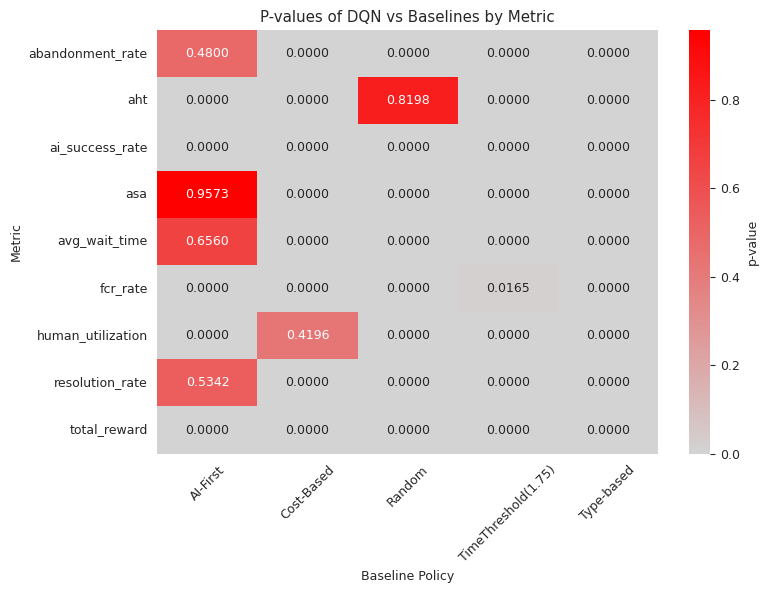

In [ ]:
# 6) Heatmap of p-values: low=grey, high=red
# Load t-test results
heatmap_df = df_ttest.pivot(index='metric', columns='policy2', values='p_value')

# custom grey-to-red colormap
gray_red = LinearSegmentedColormap.from_list("gray_red", ["lightgrey", "red"])

plt.figure(figsize=(8,6))
ax = sns.heatmap(
    heatmap_df,
    annot=True,
    fmt=".4f",
    cmap=gray_red,
    cbar_kws={'label': 'p-value'}
)
ax.set_title("P-values of DQN vs Baselines by Metric")
ax.set_xlabel("Baseline Policy")
ax.set_ylabel("Metric")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


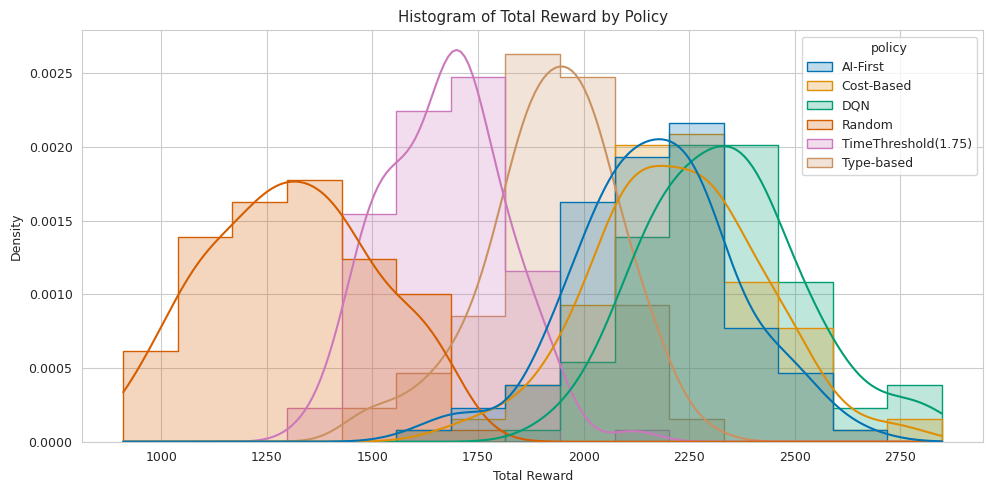

In [ ]:
# === H1 Test Visualizations: Histogram and Boxplot for Total Reward and Components ===
# Histogram: total_reward distribution by policy
plt.figure(figsize=(10,5))
sns.histplot(data=metrics_df, x='total_reward', hue='policy', element='step', stat='density', common_norm=False, kde=True)
plt.title('Histogram of Total Reward by Policy')
plt.xlabel('Total Reward')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

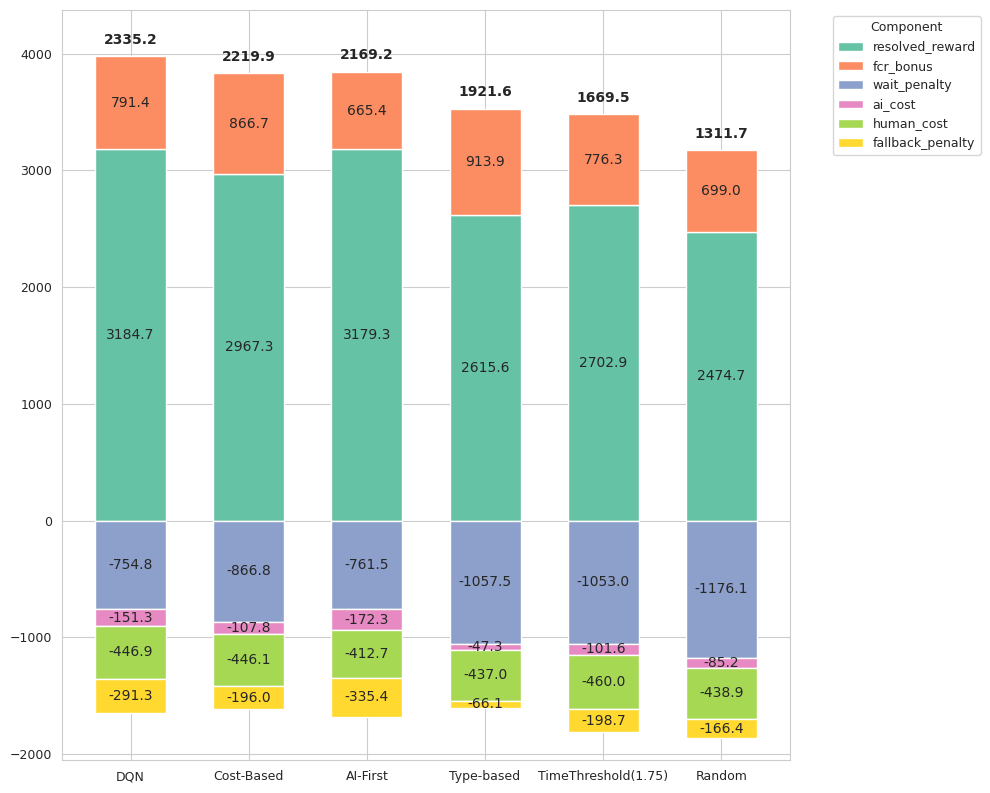

In [ ]:
# === H1 Test Visualizations: Stacked Bar Chart of Reward Components ===
# rename base_reward to resolved_reward for clarity
df['resolved_reward'] = df['base_reward']
components = ['resolved_reward','fcr_bonus','wait_penalty','ai_cost','human_cost','fallback_penalty']
# display labels for clarity
ax.bar(order, vals, bottom=neg_bottom, width=0.6, label=component_labels[comp])
# Compute per-episode component sums, then average across runs
run_comp = df.groupby(['policy','run'])[components].sum().reset_index()
breakdown_mean = run_comp.groupby('policy')[components].mean()
# Order policies by average total_reward per episode
total_mean = metrics_df.groupby('policy')['total_reward'].mean()
order = total_mean.sort_values(ascending=False).index.tolist()
breakdown_mean = breakdown_mean.loc[order]

# Define which components are negative costs/penalties
neg_comps = ['wait_penalty','ai_cost','human_cost','fallback_penalty']

# Plot stacked bar with positive rewards up and negative costs down
# increase vertical space for clarity
fig, ax = plt.subplots(figsize=(10, 8))
# Start positive stack and negative stack separately
pos_bottom = np.zeros(len(order))
neg_bottom = np.zeros(len(order))
palette = sns.color_palette("Set2", n_colors=len(components))

for i, comp in enumerate(components):
    vals = breakdown_mean[comp].values
    if comp in neg_comps:
        # invert sign for plotting
        vals = -vals
        ax.bar(order, vals, bottom=neg_bottom, width=0.6, label=component_labels.get(comp, comp), color=palette[i])
        # annotate each negative segment
        for j, v in enumerate(vals):
            if v != 0:
                ax.text(j, neg_bottom[j] + v/2, f"{v:.1f}", ha='center', va='center', fontsize=10)
        neg_bottom += vals
    else:
        ax.bar(order, vals, bottom=pos_bottom, width=0.6, label=comp, color=palette[i])
        # annotate each positive segment
        for j, v in enumerate(vals):
            if v != 0:
                ax.text(j, pos_bottom[j] + v/2, f"{v:.1f}", ha='center', va='center', fontsize=10)
        pos_bottom += vals

# add legend back for components
ax.legend(title='Component', bbox_to_anchor=(1.05, 1), loc='upper left')

# adjust y-axis limits for annotation space
ylim_low = neg_bottom.min() * 1.1
ylim_high = pos_bottom.max() * 1.1
ax.set_ylim(ylim_low, ylim_high)

# Annotate total average reward above positive stacks
for idx, policy in enumerate(order):
    top = pos_bottom[idx]
    y = top + (pos_bottom.max() * 0.02)
    ax.text(idx, y, f"{total_mean[policy]:.1f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

<ipython-input-130-c7d029512627>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


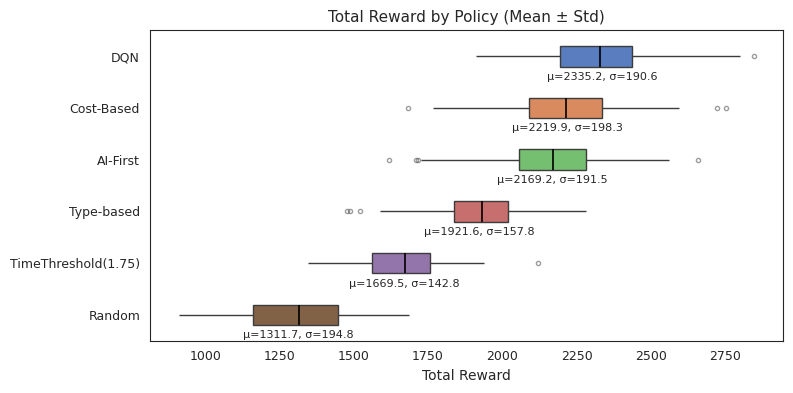

In [ ]:
# 스타일 세팅
sns.set_style('white')
plt.rc('font', size=9)

# 통계값 계산 및 내림차순 순서 결정
stats = (
    metrics_df
      .groupby('policy')['total_reward']
      .agg(['mean','std'])
      .sort_values('mean', ascending=False)
      .reset_index()
)
order = stats['policy'].tolist()

# Figure 생성
fig, ax = plt.subplots(figsize=(8, 4))

# Horizontal boxplot
sns.boxplot(
    data=metrics_df,
    y='policy', x='total_reward',
    order=order,
    width=0.4,
    palette='muted',
    showcaps=False,
    boxprops={'linewidth':1},
    whiskerprops={'linewidth':1},
    medianprops={'color':'black','linewidth':1.2},
    flierprops={'marker':'o','markersize':3,'alpha':0.5},
    ax=ax
)

# 평균(μ)과 표준편차(σ)를 각 박스 아래에 표시
for i, row in stats.iterrows():
    mu, sigma = row['mean'], row['std']
    ax.text(
        mu,                 # x 위치: 평균값 위치
        i - -0.3,           # y 위치: 해당 박스의 바로 아래
        f"μ={mu:.1f}, σ={sigma:.1f}",
        ha='center', va='top',
        fontsize=8
    )

# 레이블 및 레이아웃 정리
ax.set_title('Total Reward by Policy (Mean ± Std)', fontsize=11)
ax.set_xlabel('Total Reward', fontsize=10)
ax.set_ylabel('')
ax.grid(False)
plt.tight_layout()
plt.show()

<ipython-input-132-03d44bbe463c>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


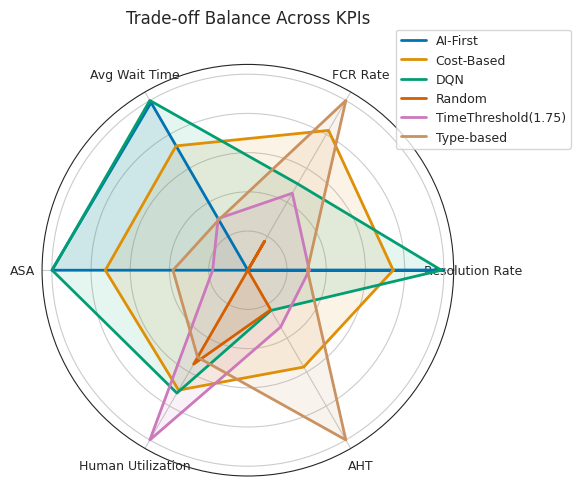

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Run-level KPI 재계산 (ASA, AHT 포함)
run_metrics = (
    df_results
      .groupby(['policy','run'])
      .apply(lambda g: pd.Series({
          'resolution_rate':   g['resolved'].mean(),
          'fcr_rate':          g['is_fcr'].mean(),
          'human_utilization': g['human_service_time'].sum()/(config.num_human_agents*config.operating_hours),
          'avg_wait_time':     g['total_wait_time'].mean(),
          'fallback_rate':     g['had_fallback'].mean(),
          # ASA: 응답된 고객의 대기시간 평균
          'asa':               g.loc[g['resolved'], 'total_wait_time'].mean(),
          # AHT: 응답된 고객의 서비스시간 합 평균
          'aht':               (g.loc[g['resolved'], 'ai_service_time']
                                + g.loc[g['resolved'], 'human_service_time']).mean()
      }))
      .reset_index()
)

metrics_df = run_metrics

# 2) 정책별 평균 KPI 계산
summary = metrics_df.groupby('policy').mean()

# 3) 레이더용 KPI 매핑
raw_metrics = {
    'Resolution Rate':    'resolution_rate',   # 높을수록 좋음
    'FCR Rate':           'fcr_rate',          # 높을수록 좋음
    'Avg Wait Time':      'avg_wait_time',     # 낮을수록 좋음
    'ASA':                'asa',               # 낮을수록 좋음
    'Human Utilization':  'human_utilization', # 높을수록 좋음
    'AHT':                'aht'                # 낮을수록 좋음
}

# 4) 0–1 정규화
norm_df = pd.DataFrame(index=summary.index)
for label, col in raw_metrics.items():
    mn, mx = summary[col].min(), summary[col].max()
    norm_df[label] = (summary[col] - mn) / (mx - mn)

# 5) '낮을수록 좋은' 지표 뒤집기
for bad in ['Avg Wait Time','ASA','AHT']:
    norm_df[bad] = 1 - norm_df[bad]

# 6) 레이더 차트 각도 계산
labels = list(raw_metrics.keys())
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # 닫힌 모양을 위해 처음 값 재추가

# 7) 레이더 차트 그리기
fig, ax = plt.subplots(figsize=(6,6), subplot_kw={'polar': True})
for policy in norm_df.index:
    vals = norm_df.loc[policy, labels].tolist()
    vals += vals[:1]
    ax.plot(angles, vals, label=policy, linewidth=2)
    ax.fill(angles, vals, alpha=0.1)

# 8) 레이블, 범례, 타이틀
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=9)
ax.set_yticklabels([])
ax.set_title('Trade-off Balance Across KPIs', y=1.08, fontsize=12)
ax.legend(loc='upper right', bbox_to_anchor=(1.3,1.1), fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
# 1) Load full customer-level results
results_path = os.path.join(RESULTS_DIR, 'simulation_results.csv')
df = pd.read_csv(results_path)

# 2) Compute run-level KPI (including total_reward, abandonment_rate, ASA, AHT)
def compute_run_metrics(sub):
    return pd.Series({
        'resolution_rate':    sub['resolved'].mean(),
        'abandonment_rate':   sub['dropped_out'].mean(),
        'fcr_rate':           sub['is_fcr'].mean(),
        'avg_wait_time':      sub['total_wait_time'].mean(),
        'total_reward':       sub['total_reward'].sum(),
        'human_utilization':  sub['human_service_time'].sum()/(config.num_human_agents*config.operating_hours),
        'asa':                sub.loc[sub['resolved'], 'total_wait_time'].mean(),
        'aht':                (sub.loc[sub['resolved'], 'ai_service_time']
                              + sub.loc[sub['resolved'], 'human_service_time']).mean()
    })

metrics_df = (
    df.groupby(['policy','run'])
      .apply(compute_run_metrics)
      .reset_index()
)

# 3) Aggregate by policy to get policy_summary
policy_summary = (
    metrics_df.groupby('policy')
      .agg({
          'total_reward':       'mean',
          'resolution_rate':    'mean',
          'abandonment_rate':   'mean',
          'fcr_rate':           'mean',
          'avg_wait_time':      'mean',
          'human_utilization':  'mean',
          'asa':                'mean',
          'aht':                'mean'
      })
      .round(4)
      .sort_values('total_reward', ascending=False)
      .reset_index()
)

print(policy_summary)

                policy  total_reward  resolution_rate  abandonment_rate  \
0                  DQN    2335.18090          0.71790           0.28200   
1           Cost-Based    2219.88030          0.67910           0.32070   
2             AI-First    2169.22120          0.71990           0.27970   
3           Type-based    1921.60370          0.61000           0.39010   
4  TimeThreshold(1.75)    1669.47680          0.61150           0.38830   
5               Random    1311.71090          0.56200           0.43750   

   fcr_rate  avg_wait_time  human_utilization     asa     aht  
0   0.48090        0.54640            0.94050 0.32590 7.50880  
1   0.52900        0.63040            0.93880 0.40600 6.94990  
2   0.40310        0.55030            0.86850 0.32540 7.90590  
3   0.55600        0.76720            0.91950 0.50790 6.22980  
4   0.47250        0.76500            0.96800 0.56780 7.34550  
5   0.42910        0.86040            0.92350 0.62080 7.51510  


<ipython-input-136-5b91fd3b0f5e>:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_run_metrics)


In [ ]:
metrics_df

,policy,run,resolution_rate,abandonment_rate,fcr_rate,avg_wait_time,total_reward,human_utilization,asa,aht
0,AI-First,1,0.71333,0.28667,0.38444,0.54238,1969.52240,0.87851,0.33459,8.37493
1,AI-First,2,0.71908,0.28092,0.38994,0.57850,2036.02072,0.88160,0.34381,7.90309
2,AI-First,3,0.70816,0.28980,0.40000,0.57545,2134.54292,0.86524,0.35243,7.85977
3,AI-First,4,0.73868,0.25720,0.42593,0.52873,2335.47769,0.85111,0.33584,7.64994
4,AI-First,5,0.71458,0.28542,0.40208,0.49769,2218.56512,0.86353,0.29716,7.98428
...,...,...,...,...,...,...,...,...,...,...
595,Type-based,96,0.64348,0.35652,0.60000,0.80398,2004.39797,0.90740,0.51051,6.12144
596,Type-based,97,0.59917,0.40083,0.55165,0.79205,1885.73120,0.93572,0.48118,6.26719
597,Type-based,98,0.59920,0.40080,0.54309,0.77053,1941.21061,0.95027,0.50648,6.25531
598,Type-based,99,0.56432,0.43361,0.52490,0.86938,1623.42784,0.91491,0.59085,6.39996


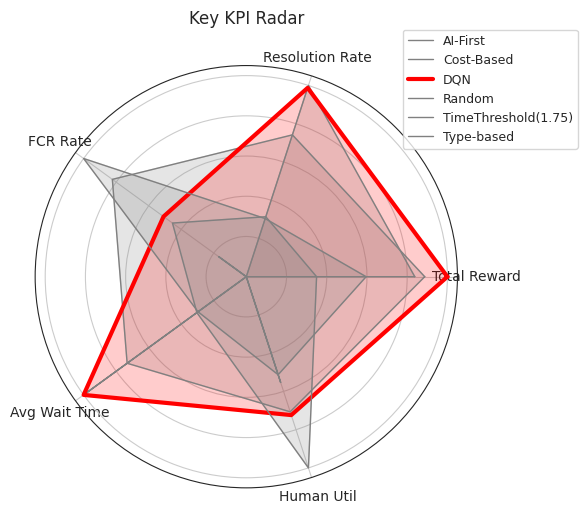

In [ ]:
# 1) run_level_metrics.csv 로드
results_path = os.path.join(RESULTS_DIR, 'run_level_metrics.csv')
df = pd.read_csv(results_path)

# 2) 정책별 평균 집계
summary = df.groupby('policy').agg({
    'total_reward':      'mean',
    'resolution_rate':   'mean',
    'fcr_rate':          'mean',
    'avg_wait_time':     'mean',
    'human_utilization': 'mean'
}).round(4)

# 3) 레이더용 지표 정규화(0–1) 및 avg_wait_time 뒤집기
metrics = {
    'Total Reward':      'total_reward',
    'Resolution Rate':   'resolution_rate',
    'FCR Rate':          'fcr_rate',
    'Avg Wait Time':     'avg_wait_time',
    'Human Util':        'human_utilization'
}

norm = pd.DataFrame(index=summary.index)
for label, col in metrics.items():
    mn, mx = summary[col].min(), summary[col].max()
    norm[label] = (summary[col] - mn) / (mx - mn)

# Avg Wait Time은 낮을수록 좋음 → 1-정규화
norm['Avg Wait Time'] = 1 - norm['Avg Wait Time']

# 4) 레이더 차트 각도 계산
labels = list(metrics.keys())
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

# 5) 그리기
fig, ax = plt.subplots(figsize=(6,6), subplot_kw={'polar': True})
for policy in norm.index:
    vals = norm.loc[policy].tolist()
    vals += vals[:1]
    lw = 3 if policy=='DQN' else 1
    color = 'red' if policy=='DQN' else 'gray'
    ax.plot(angles, vals, label=policy, linewidth=lw, color=color)
    ax.fill(angles, vals, alpha=0.2, color=color)

# 6) 레이블 및 범례
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10)
ax.set_yticklabels([])
ax.set_title('Key KPI Radar', y=1.08, fontsize=12)
ax.legend(loc='upper right', bbox_to_anchor=(1.3,1.1), fontsize=9)

plt.tight_layout()
plt.show()

<ipython-input-142-dda00cc0fb19>:65: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0.15, 1, 1])


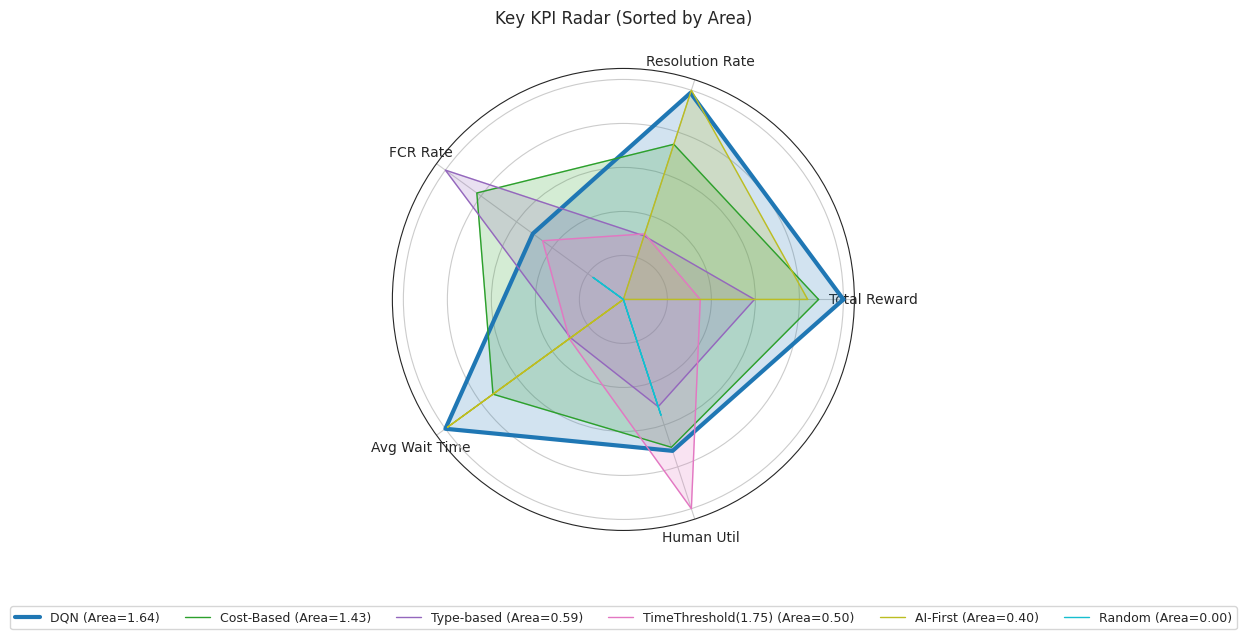

In [ ]:

# 1) 정책별 평균 KPI 집계
summary = metrics_df.groupby('policy').agg({
    'total_reward':      'mean',
    'resolution_rate':   'mean',
    'fcr_rate':          'mean',
    'avg_wait_time':     'mean',
    'human_utilization': 'mean'
}).round(4)

# 2) 0–1 정규화 및 Avg Wait Time 뒤집기
metrics = {
    'Total Reward':      'total_reward',
    'Resolution Rate':   'resolution_rate',
    'FCR Rate':          'fcr_rate',
    'Avg Wait Time':     'avg_wait_time',
    'Human Util':        'human_utilization'
}
norm = pd.DataFrame(index=summary.index)
for label, col in metrics.items():
    mn, mx = summary[col].min(), summary[col].max()
    norm[label] = (summary[col] - mn) / (mx - mn)
norm['Avg Wait Time'] = 1 - norm['Avg Wait Time']

# 3) 레이더 차트 각도 계산
labels = list(metrics.keys())
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

# 4) 다각형 면적 계산 (shoelace)
areas = {}
for policy in norm.index:
    vals = norm.loc[policy, labels].tolist() + [norm.loc[policy, labels[0]]]
    x = [v * np.cos(a) for v, a in zip(vals, angles)]
    y = [v * np.sin(a) for v, a in zip(vals, angles)]
    areas[policy] = 0.5 * abs(sum(x[i]*y[i+1] - x[i+1]*y[i] for i in range(len(vals)-1)))

# 5) Area 내림차순으로 정책 정렬
sorted_policies = sorted(areas, key=areas.get, reverse=True)

# 6) 레이더 차트 그리기
fig, ax = plt.subplots(figsize=(6,6), subplot_kw={'polar': True})
colors = plt.cm.tab10(np.linspace(0,1,len(sorted_policies)))

for color, policy in zip(colors, sorted_policies):
    vals = norm.loc[policy, labels].tolist() + [norm.loc[policy, labels[0]]]
    linewidth = 3 if policy=='DQN' else 1
    ax.plot(angles, vals,
            label=f"{policy} (Area={areas[policy]:.2f})",
            linewidth=linewidth, color=color)
    ax.fill(angles, vals, alpha=0.2, color=color)

# 7) 범례를 차트 아래 중앙에 배치
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10)
ax.set_yticklabels([])
ax.set_title('Key KPI Radar (Sorted by Area)', y=1.08, fontsize=12)
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=len(sorted_policies),
    fontsize=9
)

# 여백 조정: 범례 공간 확보
plt.tight_layout(rect=[0, 0.15, 1, 1])
plt.show()

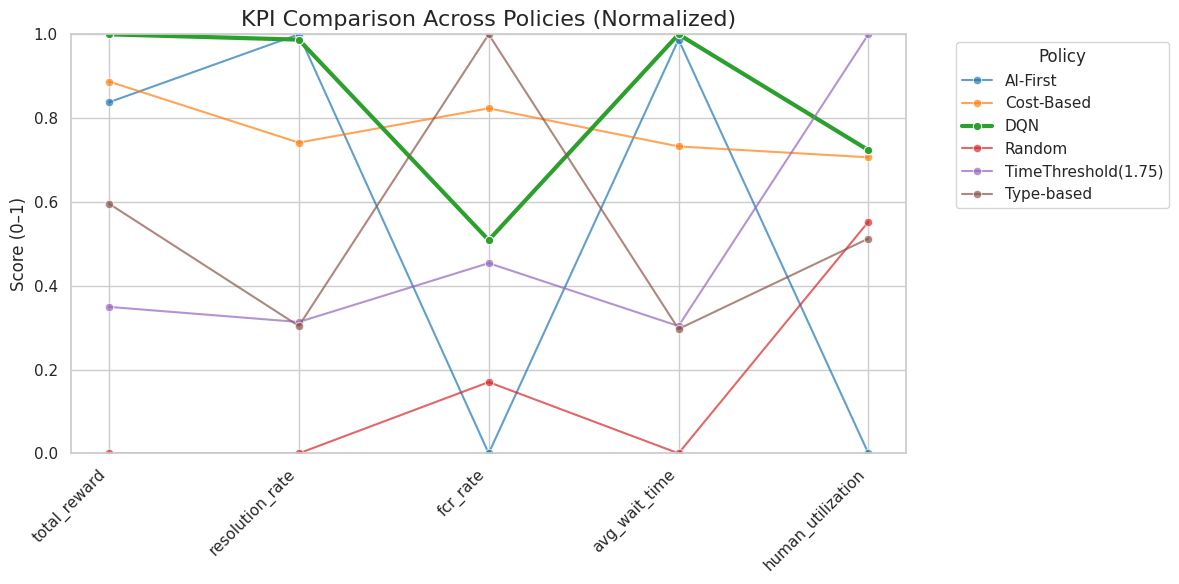

In [ ]:
# Set style
sns.set(style="whitegrid")

# 1) Load run-level metrics
results_path = os.path.join(RESULTS_DIR, 'run_level_metrics.csv')
df = pd.read_csv(results_path)

# 2) Compute policy-level averages
summary = df.groupby('policy').agg({
    'total_reward':      'mean',
    'resolution_rate':   'mean',
    'fcr_rate':          'mean',
    'avg_wait_time':     'mean',
    'human_utilization': 'mean'
}).round(4)

# 3) Normalize metrics and invert 'avg_wait_time'
kpis = ['total_reward', 'resolution_rate', 'fcr_rate', 'avg_wait_time', 'human_utilization']
norm = summary.copy()
for col in kpis:
    mn, mx = summary[col].min(), summary[col].max()
    norm[col] = (summary[col] - mn) / (mx - mn)
norm['avg_wait_time'] = 1 - norm['avg_wait_time']  # invert

# 4) Prepare plot
plt.figure(figsize=(12, 6))
palette = sns.color_palette("tab10", n_colors=len(norm))
for idx, policy in enumerate(norm.index):
    if policy == 'DQN':
        sns.lineplot(x=kpis, y=norm.loc[policy, kpis],
                     label=policy, color=palette[idx], linewidth=3, marker="o")
    else:
        sns.lineplot(x=kpis, y=norm.loc[policy, kpis],
                     label=policy, color=palette[idx], linewidth=1.5, alpha=0.7, marker="o")

# 5) Final touches
plt.title('KPI Comparison Across Policies (Normalized)', fontsize=16)
plt.ylabel('Score (0–1)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.legend(title='Policy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

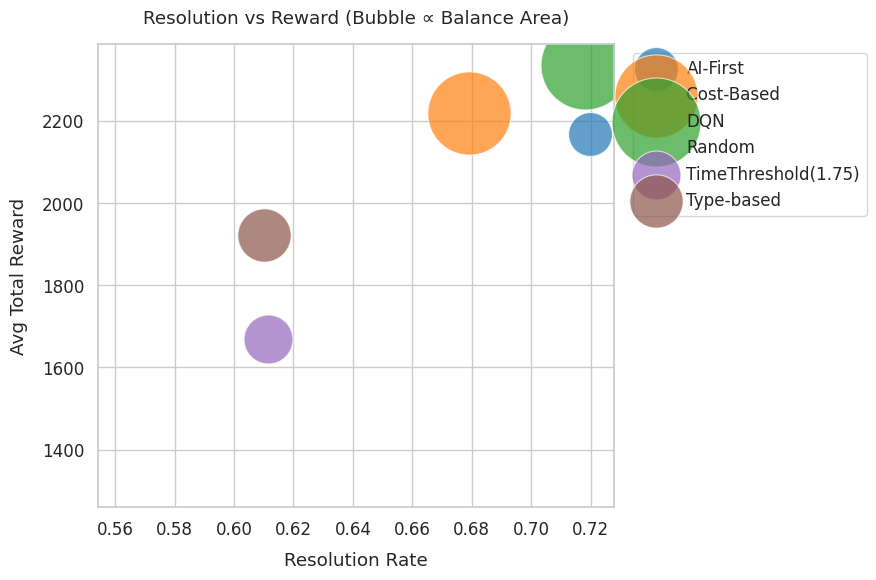

In [ ]:
# 0) 준비: seaborn 스타일
sns.set(style="whitegrid", font_scale=1.1)

# 1) run-level 데이터가 df_results 에 로드되어 있다고 가정
# df_results = pd.read_csv("./results/simulation_results.csv")
# metrics_df = ... (run_metrics 계산 코드)

# 2) 정책별 평균 KPI 계산
summary = metrics_df.groupby('policy').agg({
    'total_reward':      'mean',
    'resolution_rate':   'mean',
    'fcr_rate':          'mean',
    'avg_wait_time':     'mean',
    'human_utilization': 'mean'
}).round(4)

# 3) 0–1 정규화 및 Avg Wait Time 뒤집기
kpis = ['total_reward', 'resolution_rate', 'fcr_rate', 'avg_wait_time', 'human_utilization']
norm = pd.DataFrame(index=summary.index)
for col in kpis:
    mn, mx = summary[col].min(), summary[col].max()
    norm[col] = (summary[col] - mn) / (mx - mn)
norm['avg_wait_time'] = 1 - norm['avg_wait_time']

# 4) Balance area 계산 (shoelace 공식을 이용)
angles = np.linspace(0, 2*np.pi, len(kpis), endpoint=False).tolist()
angles += angles[:1]
areas = {}
for policy in norm.index:
    vals = norm.loc[policy, kpis].tolist() + [norm.loc[policy, kpis[0]]]
    x = [v * np.cos(a) for v, a in zip(vals, angles)]
    y = [v * np.sin(a) for v, a in zip(vals, angles)]
    areas[policy] = 0.5 * abs(sum(x[i]*y[i+1] - x[i+1]*y[i] for i in range(len(vals)-1)))

# --- 1) Bubble Chart ---
plt.figure(figsize=(9,6))
palette = sns.color_palette("tab10", n_colors=len(summary))
for i, policy in enumerate(summary.index):
    plt.scatter(
        summary.loc[policy, 'resolution_rate'],
        summary.loc[policy, 'total_reward'],
        s=areas[policy]*2500,
        color=palette[i],
        alpha=0.7,
        edgecolor='white',
        linewidth=0.8,
        label=policy
    )
plt.xlabel('Resolution Rate', labelpad=10)
plt.ylabel('Avg Total Reward', labelpad=10)
plt.title('Resolution vs Reward (Bubble ∝ Balance Area)', pad=15)
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left', frameon=True)
plt.tight_layout()
plt.show()

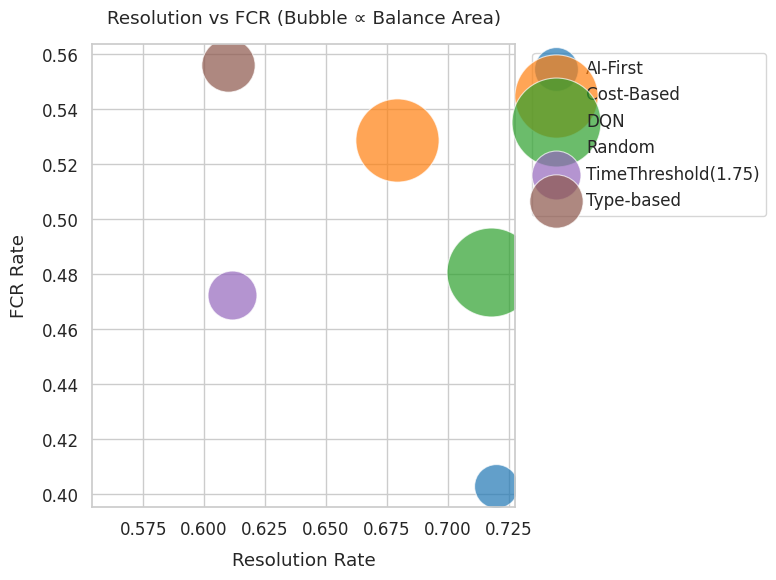

In [ ]:
sns.set(style="whitegrid", font_scale=1.1)

# 1) 정책별 평균 KPI 계산
summary = metrics_df.groupby('policy').agg({
    'resolution_rate': 'mean',
    'fcr_rate':        'mean'
}).round(4)

# 2) Bubble Chart 그리기
plt.figure(figsize=(8,6))
palette = sns.color_palette("tab10", n_colors=len(summary))

for i, policy in enumerate(summary.index):
    plt.scatter(
        summary.loc[policy, 'resolution_rate'],
        summary.loc[policy, 'fcr_rate'],
        s=areas[policy] * 2500,      # balance area 크기에 비례
        color=palette[i],
        alpha=0.7,
        edgecolor='white',
        linewidth=0.8,
        label=policy
    )

plt.xlabel('Resolution Rate', labelpad=10)
plt.ylabel('FCR Rate', labelpad=10)
plt.title('Resolution vs FCR (Bubble ∝ Balance Area)', pad=15)
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left', frameon=True)
plt.tight_layout()
plt.show()

<ipython-input-147-bb636681c80b>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


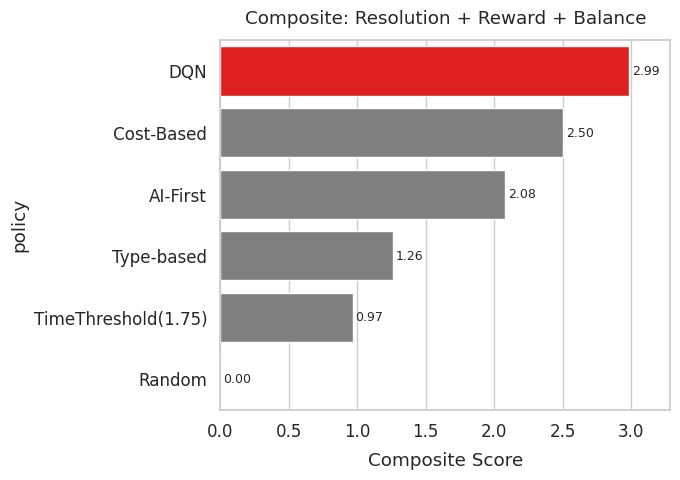

In [ ]:
# --- 2) Composite Score Bar Chart ---
nr = (summary['resolution_rate'] - summary['resolution_rate'].min()) / \
     (summary['resolution_rate'].max() - summary['resolution_rate'].min())
nt = (summary['total_reward'] - summary['total_reward'].min()) / \
     (summary['total_reward'].max() - summary['total_reward'].min())
na = pd.Series(areas)
na = (na - na.min()) / (na.max() - na.min())
composite = (nr + nt + na).sort_values(ascending=False)

plt.figure(figsize=(7,5))
sns.barplot(
    x=composite.values,
    y=composite.index,
    palette=[("red" if p=="DQN" else "gray") for p in composite.index]
)
plt.xlabel('Composite Score', labelpad=8)
plt.title('Composite: Resolution + Reward + Balance', pad=12)
for idx, v in enumerate(composite):
    plt.text(v + 0.02, idx, f"{v:.2f}", va='center', fontsize=9)
plt.xlim(0, composite.max()+0.3)
plt.tight_layout()
plt.show()

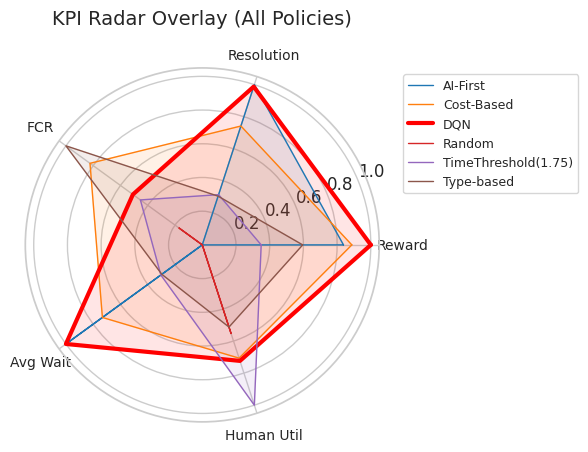

In [ ]:
# --- 3) Radar Overlay ---
labels = ['Reward','Resolution','FCR','Avg Wait','Human Util']
fig, ax = plt.subplots(figsize=(6,6), subplot_kw={'polar': True})
for i, policy in enumerate(norm.index):
    vals = [
        norm.loc[policy, 'total_reward'],
        norm.loc[policy, 'resolution_rate'],
        norm.loc[policy, 'fcr_rate'],
        norm.loc[policy, 'avg_wait_time'],
        norm.loc[policy, 'human_utilization']
    ]
    vals += vals[:1]
    lw = 3 if policy=='DQN' else 1
    col = ("red" if policy=="DQN" else palette[i])
    ax.plot(angles, vals, label=policy, linewidth=lw, color=col)
    ax.fill(angles, vals, alpha=0.1, color=col)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10)
ax.set_title('KPI Radar Overlay (All Policies)', y=1.1, fontsize=14)
ax.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
df_results = pd.read_csv(os.path.join(RESULTS_DIR, 'simulation_results.csv'))

metrics_df = (
    df_results
    .groupby(['policy','run'])
    .apply(lambda g: pd.Series({
        'resolution_rate':   g['resolved'].mean(),
        'avg_wait_time':     g['total_wait_time'].mean(),
        'total_reward':      g['total_reward'].sum()
    }))
    .reset_index()
)

# 이후, 위 CV 및 boxplot 코드를 실행

<ipython-input-150-d0dcafc5d748>:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


<ipython-input-172-0b84e71ab3cf>:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ts = df_time.groupby('t_bin')['action'].mean().reset_index()


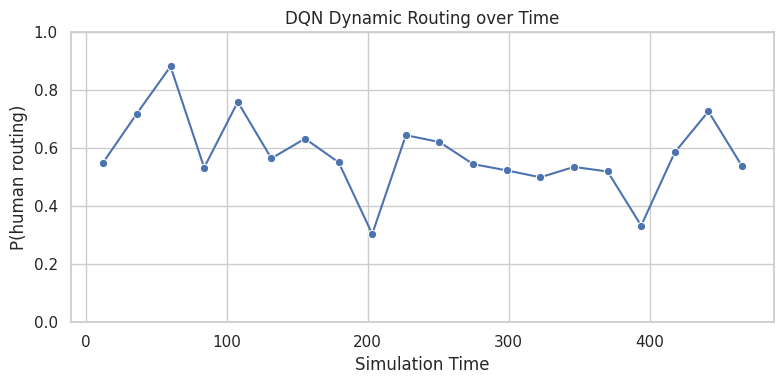

In [ ]:
# 0) DQN 정책 로드
dqn_policy = RLPolicy(
    model_path=os.path.join(config.models_dir, "dqn_model.pth"),
    network_type="DQN"
)

# 1) 시뮬레이터 돌리고 로그 수집
records = []
sim = AICCSimulator(config)
done = False
while not done:
    cust, done = sim.step()
    if cust is not None:
        t = sim.current_time
        action = dqn_policy.route(cust, sim)  # 이제 dqn_policy가 정의되어 있으니 에러 없음
        records.append({
            'time': t,
            'queue': len(sim.human_queue),
            'remaining_time': (config.operating_hours - t) / config.operating_hours,
            'problem': cust.problem_type,
            'action': action
        })

df_time = pd.DataFrame(records)

# 2) 시간 binning & P(human) 계산
df_time['t_bin'] = pd.cut(df_time['time'], bins=20)
ts = df_time.groupby('t_bin')['action'].mean().reset_index()
ts['t_center'] = ts['t_bin'].apply(lambda x: x.left + (x.right - x.left)/2)

# 3) 시각화
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.lineplot(x='t_center', y='action', data=ts, marker='o')
plt.ylim(0,1)
plt.xlabel("Simulation Time")
plt.ylabel("P(human routing)")
plt.title("DQN Dynamic Routing over Time")
plt.grid(True)
plt.tight_layout()
plt.show()